In [ ]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path(r"D:\Documents\Skripsi\demand-forecasting")
RAW_DIR  = PROJECT_ROOT / "data" / "data_raw"
EKS_DIR  = PROJECT_ROOT / "data" / "data_eks"
STD_DIR  = PROJECT_ROOT / "data" / "standardized"
OUT_DIR  = PROJECT_ROOT / "outputs"
DATASET15_DIR   = PROJECT_ROOT / "data" / "dataset_15"
DATASETFULL_DIR = PROJECT_ROOT / "data" / "dataset_full"
EDA15_DIR = OUT_DIR / "eda_dataset_15"

# bikin folder output 
for d in [STD_DIR, OUT_DIR, DATASET15_DIR, DATASETFULL_DIR, EDA15_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# daftar file penjualan per cabang yang akan dibaca
FILE_LIST = [
    RAW_DIR / "02A_Medan.xlsx",
    RAW_DIR / "05A_Padang.xlsx",
    RAW_DIR / "13A_Bekasi.xlsx",
    RAW_DIR / "13I_Bandung.xlsx",
    RAW_DIR / "14A_Tegal.xlsx",
    RAW_DIR / "16C_Surabaya.xlsx",
    RAW_DIR / "17A_Bali.xlsx",
    RAW_DIR / "23A_Samarinda.xlsx",
    RAW_DIR / "29A_Kendari.xlsx",
]

# mapping kode cabang ke kode area
AREA_MAP = {
    "02A": "1A", "05A": "1B", "13A": "02", "13I": "3",
    "14A": "04", "16C": "05", "17A": "08", "23A": "07", "29A": "06"
}

# set window waktu untuk train dan test
WIN_START  = pd.Timestamp("2021-01-01")
TRAIN_END  = pd.Timestamp("2024-05-01")
TEST_START = pd.Timestamp("2024-06-01")
TEST_END   = pd.Timestamp("2024-10-01")

# set file data eksternal (event, libur, hujan)
F_EVENTS  = EKS_DIR / "event_gatering.xlsx"
F_HOL     = EKS_DIR / "hari_libur_nasional.xlsx"
F_RAIN_16 = EKS_DIR / "curah_hujan_Surabaya.xlsx"

# daftar SKU yang dipakai khusus 16C tahun 2023 karena data lain tidak lengkap
SKU_16C_VALID_2023 = [
    "BUVW001KSW","DOPQ001K002","BKLM200CHAR","BKLM200CPOX","EVWX200CHAR",
    "BKLM001KHAR","BKLM001KPOX","DOPQ004K002","DOPQ001K009","BUVW001KSB",
    "BNOP400CPOX","FIJK250C","CKLM001KS600","ATUV005KSW","BVWX001KA",
    "CFGH001K711","BUVW001K192","EVW001KGRE",
]

# daftar SKU yang dipakai khusus 23A bulan Mei 2024 karena data lain tidak lengkap
SKU_23A_KEEP_MAY24 = {
    "AUVW001KA","AUVW001KASP","BKLM200CHAR","BKLM200CPOX","BNOP400CHAR",
    "BNOP400CPOX","BUVW001KSB","BUVW001KSW","BUVW200CSW","FIJK250C",
}


In [ ]:
def load_sales_monthly(files, area_map):
    dfs = []
    for f in files:
        # Baca data penjualan per cabang, ambil kolom yang dipakai
        df = pd.read_excel(f).rename(columns={
            "Posting Date":  "date",
            "Location Code": "cabang_raw",
            "SKU":           "sku",
            "Quantity":      "qty_raw",
        })

        # Bikin quantity jadi angka, yang bukan angka dibuang
        df["qty"] = pd.to_numeric(df["qty_raw"], errors="coerce")
        df = df.dropna(subset=["qty"])

        # Ambil kode cabang dari Location Code
        df["cabang"] = (
            df["cabang_raw"]
            .astype(str)
            .str.split("-")
            .str[0]
            .str.strip()
        )

        # Mapping cabang ke area
        df["area"] = df["cabang"].map(area_map).fillna(df["cabang"])

        # Ubah tanggal transaksi jadi periode bulanan
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.dropna(subset=["date"])
        df["periode"] = df["date"].dt.to_period("M").dt.to_timestamp()

        # Gabung transaksi harian jadi nilai netto per bulan
        g = (
            df.groupby(["periode", "area", "cabang", "sku"], as_index=False)
              .agg(qty_net=("qty", "sum"))
        )

        # Ubah qty netto jadi demand positif
        g["qty"] = -g["qty_net"]
        g.loc[g["qty"] < 0, "qty"] = 0.0
        g = g.drop(columns=["qty_net"])

        dfs.append(g)

    # Gabung semua cabang jadi satu data bulanan
    out = (
        pd.concat(dfs, ignore_index=True)
          .sort_values(["cabang", "sku", "periode"])
          .reset_index(drop=True)
    )
    return out[["periode", "area", "cabang", "sku", "qty"]]


# Jalanin fungsi buat bikin data sales bulanan semua cabang
sales_m = load_sales_monthly(FILE_LIST, AREA_MAP)

# --- exception 1: cabang 16C tahun 2023 datanya ga lengkap ---
# jadi khusus 16C tahun 2023, cuma keep SKU yang ada di whitelist
m_16_2023 = (sales_m["cabang"] == "16C") & (sales_m["periode"].dt.year == 2023)
sales_m = pd.concat(
    [
        sales_m[~m_16_2023],  # data selain 16C tahun 2023 tetap dipakai semua
        sales_m[m_16_2023 & (sales_m["sku"].isin(SKU_16C_VALID_2023))],  # 16C 2023 disaring
    ],
    ignore_index=True,
)

# --- exception 2: cabang 23A bulan Mei 2024 datanya ga lengkap ---
# jadi khusus 23A di 2024-05, cuma keep SKU yang ada di whitelist
m_23a_may24 = (sales_m["cabang"] == "23A") & (sales_m["periode"] == pd.Timestamp("2024-05-01"))
sales_m = pd.concat(
    [
        sales_m[~m_23a_may24],  # data selain 23A Mei 2024 tetap dipakai semua
        sales_m[m_23a_may24 & (sales_m["sku"].isin(SKU_23A_KEEP_MAY24))],  # 23A Mei 2024 disaring
    ],
    ignore_index=True,
)

# Rapihin urutan biar time series per SKU kebaca rapi
sales_m = sales_m.sort_values(["cabang", "sku", "periode"]).reset_index(drop=True)

# Simpan hasil final setelah exception ke CSV (buat dipakai step berikutnya)
sales_m.to_csv(STD_DIR / "sales_monthly_after_area_exceptions.csv", index=False)


IMPUTE 0, IS_ACTIVE, IS_TRAIN/TEST

In [ ]:
def make_windowed_panel(df, area_map):
    out = []

    # proses per cabang-SKU (1 time series)
    for (cab, sku), g in df.groupby(["cabang", "sku"], sort=False):

        # urut per bulan
        g = g.sort_values("periode")

        # ambil kalender bulanan dari bulan min sampai max
        cal = pd.date_range(g["periode"].min(), g["periode"].max(), freq="MS")

        # tambah bulan yang hilang (reindex ke kalender penuh)
        idx = pd.MultiIndex.from_product([[cab], [sku], cal], names=["cabang", "sku", "periode"])
        g2 = g.set_index(["cabang", "sku", "periode"]).reindex(idx).reset_index()

        # ambil list bulan yang memang ada di data asli
        exist = set(zip(g["cabang"], g["sku"], g["periode"]))

        # qty jadi angka, yang kosong jadi 0
        g2["qty"] = pd.to_numeric(g2["qty"], errors="coerce").fillna(0.0)

        # tanda 1 kalau bulan hasil ditambahin
        g2["imputed"] = [0 if (cab, sku, p) in exist else 1 for p in g2["periode"]]

        # mapping cabang ke area
        g2["area"] = g2["cabang"].map(area_map).fillna(g2["cabang"])

        # aktif cuma dari non-zero pertama sampai non-zero terakhir
        nz_idx = g2.index[g2["qty"] != 0]
        if len(nz_idx):
            left, right = int(nz_idx.min()), int(nz_idx.max())
            g2["is_active"] = 0
            g2.loc[left:right, "is_active"] = 1
        else:
            g2["is_active"] = 0

        # simpan hasil per cabang-SKU
        out.append(g2[["periode", "area", "cabang", "sku", "qty", "imputed", "is_active"]])

    # gabung semua cabang-SKU jadi 1 panel
    return (
        pd.concat(out, ignore_index=True)
          .sort_values(["cabang", "sku", "periode"])
          .reset_index(drop=True)
    )


# bikin panel bulanan lengkap
panel = make_windowed_panel(sales_m, AREA_MAP)

# ambil non-zero pertama & terakhir per cabang-SKU
nz_bounds = (
    panel.loc[panel["qty"].ne(0)]
         .groupby(["cabang", "sku"], sort=False)["periode"]
         .agg(train_start="min", nz_last="max")
         .reset_index()
)

# gabung batas non-zero ke panel
panel = panel.merge(nz_bounds, on=["cabang", "sku"], how="left")

# label train: aktif, ada start non-zero, dan masuk rentang train
panel["is_train"] = (
    (panel["is_active"] == 1) &
    panel["train_start"].notna() &
    (panel["periode"] >= panel["train_start"]) &
    (panel["periode"] <= TRAIN_END)
).astype(int)

# label test: aktif dan masuk rentang test
panel["is_test"] = (
    (panel["is_active"] == 1) &
    (panel["periode"] >= TEST_START) &
    (panel["periode"] <= TEST_END)
).astype(int)


LOAD EKSOGEN & MERGE

In [ ]:
import numpy as np
import pandas as pd

# baca tanggal spreadsheet: coba parse normal dulu, kalau gagal baru anggap serial (1899-12-30)
def parse_spreadsheet_date(s, dayfirst=True, serial_origin="1899-12-30", serial_threshold=0.8):
    dt = pd.to_datetime(s, errors="coerce", dayfirst=dayfirst)

    # kalau mayoritas gagal, biasanya ini angka serial spreadsheet
    if dt.isna().mean() > serial_threshold:
        dt = pd.to_datetime(
            pd.to_numeric(s, errors="coerce"),
            origin=serial_origin,
            unit="D",
            errors="coerce"
        )
    return dt

# samain tanggal jadi awal bulan (YYYY-MM-01) biar gampang digabung ke panel bulanan
def _to_month_start(s):
    dt = parse_spreadsheet_date(s)
    return dt.dt.to_period("M").dt.to_timestamp()

# baca file event, rapihin jadi format: periode, cabang, event_flag
def load_events_any(xlsx_path):
    # baca data event
    df = pd.read_excel(xlsx_path)
    df.columns = [str(c).strip().lower() for c in df.columns]

    # ambil kolom tanggal yang paling cocok (kalau ga ketemu, pakai kolom pertama)
    date_candidates = {"gatering date","gathering date","periode","period","month","bulan","date","tanggal"}
    date_col = next((c for c in df.columns if c in date_candidates), None) or df.columns[0]

    # cek bentuk file event (long vs wide)
    is_long = ("cabang" in df.columns) and any(c in df.columns for c in ["event","event_flag","eventflag"])

    # kalau long, ambil langsung kolomnya
    if is_long:
        df = df.rename(columns={"event":"event_flag","eventflag":"event_flag", date_col:"periode"})
        ev = df[["periode","cabang","event_flag"]].copy()

    # kalau wide, ubah jadi long pakai melt
    else:
        tmp = df.rename(columns={date_col:"periode"})
        value_cols = [c for c in tmp.columns if c != "periode" and tmp[c].notna().any()]
        ev = tmp.melt(id_vars=["periode"], value_vars=value_cols, var_name="cabang", value_name="event_flag")

    # rapihin periode dan buang yang tanggalnya kosong
    ev["periode"] = _to_month_start(ev["periode"])
    ev = ev.dropna(subset=["periode"])

    # rapihin cabang (hapus suffix kayak -SBY / _SBY)
    ev["cabang"] = (
        ev["cabang"].astype(str)
          .str.strip()
          .str.upper()
          .str.replace(r"[-_].*$", "", regex=True)
    )

    # event_flag jadi angka, yang kosong jadi 0
    ev["event_flag"] = pd.to_numeric(ev["event_flag"], errors="coerce").fillna(0).astype(int).clip(lower=0)

    # urutkan dan buang duplikat
    return (
        ev[["periode","cabang","event_flag"]]
        .drop_duplicates()
        .sort_values(["cabang","periode"])
        .reset_index(drop=True)
    )

# baca libur nasional bulanan, rapihin jadi: periode, holiday_count
def load_holidays_monthly_strict(path_like):
    # baca file libur (csv atau excel)
    hol = pd.read_csv(path_like) if str(path_like).lower().endswith(".csv") else pd.read_excel(path_like)
    hol.columns = [str(c).strip().lower() for c in hol.columns]

    # kalau ga ada kolom periode, pakai kolom pertama
    if "periode" not in hol.columns:
        hol = hol.rename(columns={hol.columns[0]:"periode"})

    # kalau ga ada holiday_count, ambil kolom selain periode
    if "holiday_count" not in hol.columns:
        c1 = next((c for c in hol.columns if c != "periode"), None)
        hol = hol.rename(columns={c1:"holiday_count"}) if c1 else hol.assign(holiday_count=0)

    # periode jadi awal bulan, yang kosong dibuang
    hol["periode"] = _to_month_start(hol["periode"])
    hol = hol.dropna(subset=["periode"])

    # holiday_count jadi angka, yang kosong jadi 0
    hol["holiday_count"] = pd.to_numeric(hol["holiday_count"], errors="coerce").fillna(0).astype(int).clip(0, 31)

    # urutkan dan buang duplikat
    return (
        hol[["periode","holiday_count"]]
        .drop_duplicates()
        .sort_values("periode")
        .reset_index(drop=True)
    )

# baca hujan harian Surabaya (16C), terus jadi total hujan bulanan
def load_rain_16c(xlsx_path):
    # baca data hujan
    rf = pd.read_excel(xlsx_path)
    rf.columns = [c.strip().lower() for c in rf.columns]

    # ambil kolom tanggal dan kolom hujan
    date_col = next((c for c in rf.columns if "tanggal" in c or "date" in c), rf.columns[0])
    rain_col = next((c for c in rf.columns if "rr" in c or "rain" in c), None)
    if rain_col is None:
        raise ValueError("Kolom RR/rain tidak ditemukan.")

    # rapihin nama kolom biar seragam
    rf = rf.rename(columns={date_col:"date", rain_col:"rain"})

    # parse tanggal (format normal atau serial spreadsheet)
    rf["date"] = parse_spreadsheet_date(rf["date"])

    # buang tanggal kosong, rapihin nilai hujan
    rf = rf.dropna(subset=["date"])
    rf["rain"] = pd.to_numeric(rf["rain"], errors="coerce")
    rf.loc[(rf["rain"] == 8888) | (rf["rain"] < 0), "rain"] = np.nan

    # gabung per hari, tambah tanggal yang hilang, lalu isi pakai interpolasi
    daily = rf.groupby("date", as_index=False)["rain"].mean().sort_values("date")
    full_days = pd.date_range(daily["date"].min(), daily["date"].max(), freq="D")
    df1 = daily.set_index("date").reindex(full_days)
    df1.index.name = "date"
    df1["rain"] = df1["rain"].interpolate("linear", limit_direction="both").clip(lower=0)

    # ubah ke bulanan dan jumlahin jadi total hujan per bulan
    d2 = df1.reset_index()
    d2["periode"] = d2["date"].dt.to_period("M").dt.to_timestamp()
    rain_16 = d2.groupby("periode", as_index=False)["rain"].sum().rename(columns={"rain":"rainfall"})
    rain_16["cabang"] = "16C"

    return rain_16[["periode","cabang","rainfall"]]

# baca semua data eksternal
events  = load_events_any(F_EVENTS)
hol     = load_holidays_monthly_strict(F_HOL)
rain_16 = load_rain_16c(F_RAIN_16)

# gabung eksternal ke panel utama
panel_exog = (
    panel
    .merge(events,  on=["periode","cabang"], how="left")
    .merge(hol,     on=["periode"],         how="left")
    .merge(rain_16, on=["periode","cabang"], how="left")
    .sort_values(["cabang","sku","periode"])
    .reset_index(drop=True)
)

# isi yang kosong jadi 0 biar fitur ga jadi NaN
panel_exog["event_flag"]    = pd.to_numeric(panel_exog["event_flag"], errors="coerce").fillna(0).astype(int)
panel_exog["holiday_count"] = pd.to_numeric(panel_exog["holiday_count"], errors="coerce").fillna(0).astype(int)
panel_exog["rainfall"]      = pd.to_numeric(panel_exog["rainfall"], errors="coerce").fillna(0.0)

# ambil lag 1 bulan untuk eksternal
for c in ["event_flag","holiday_count","rainfall"]:
    panel_exog[f"{c}_lag1"] = panel_exog.groupby(["cabang","sku"], sort=False)[c].shift(1)

# ambil lag qty sampai 12 bulan
MAX_LAG = 12
for k in range(1, MAX_LAG + 1):
    panel_exog[f"qty_lag{k}"] = panel_exog.groupby(["cabang","sku"], sort=False)["qty"].shift(k)

# ambil rolling mean/std dari qty (shift 1 dulu biar ga bocor)
for w in [3, 6, 12]:
    panel_exog[f"qty_rollmean_{w}"] = (
        panel_exog.groupby(["cabang","sku"], sort=False)["qty"]
                 .transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
    )
    panel_exog[f"qty_rollstd_{w}"] = (
        panel_exog.groupby(["cabang","sku"], sort=False)["qty"]
                 .transform(lambda s: s.shift(1).rolling(w, min_periods=2).std(ddof=1))
    )

# ambil fitur waktu dari periode
panel_exog["month"] = panel_exog["periode"].dt.month
panel_exog["year"]  = panel_exog["periode"].dt.year
panel_exog["qtr"]   = panel_exog["periode"].dt.quarter

# cek hujan cuma muncul di 16C
assert panel_exog.query("cabang!='16C' and rainfall>0").empty


SELEKSI 15 SKU PER CABANG

In [ ]:
import pandas as pd

def build_selection_window(df, win_start, train_end):
    out = []

    # ambil data dalam window seleksi (awal histori sampai akhir train)
    w = df.query("periode >= @win_start and periode <= @train_end").copy()

    # ambil tanda: SKU masih ada data di bulan train terakhir (sinkron sampai train_end)
    has_may = (
        w.query("periode == @train_end")
         .groupby(["cabang", "sku"], as_index=False)
         .size()
         .rename(columns={"size": "has_may24"})
    )

    # ambil ringkasan histori selama window
    agg = (
        w.groupby(["cabang", "sku"], as_index=False)
         .agg(
             n_months=("qty", "size"),
             nonzero_months=("qty", lambda s: (s > 0).sum()),
             total_qty=("qty", "sum"),
         )
    )

    # ambil total qty 12 bulan terakhir (siklus tahunan)
    last12 = (
        w.sort_values(["cabang", "sku", "periode"])
         .groupby(["cabang", "sku"], as_index=False)
         .agg(qty_12m=("qty", lambda s: s.tail(12).sum()))
    )

    # ambil total qty 6 bulan terakhir (indikator SKU aktif atau ga)
    last6 = (
        w.sort_values(["cabang", "sku", "periode"])
         .groupby(["cabang", "sku"], as_index=False)
         .agg(qty_6m=("qty", lambda s: s.tail(6).sum()))
    )

    # ambil data yang masuk train buat hitung kepadatan nol
    t = df.loc[df["is_train"] == 1].copy()

    # ambil rasio bulan bernilai 0 selama train
    zr = (
        t.groupby(["cabang", "sku"], as_index=False)
         .agg(zero_ratio_train=("qty", lambda s: (s == 0).mean()))
    )

    # ambil jumlah bulan train yang kepake
    ntr = (
        t.groupby(["cabang", "sku"], as_index=False)["qty"]
         .count()
         .rename(columns={"qty": "n_train"})
    )

    # ambil bulan terakhir yang masih non-zero di train
    nz = (
        t.loc[t["qty"] > 0]
         .groupby(["cabang", "sku"], as_index=False)["periode"]
         .max()
         .rename(columns={"periode": "last_nz"})
    )

    # gabung semua ringkasan jadi 1 tabel per cabang-SKU
    info = (
        agg.merge(last12, on=["cabang", "sku"], how="left")
           .merge(last6,  on=["cabang", "sku"], how="left")
           .merge(has_may, on=["cabang", "sku"], how="left")
           .merge(zr, on=["cabang", "sku"], how="left")
           .merge(ntr, on=["cabang", "sku"], how="left")
           .merge(nz, on=["cabang", "sku"], how="left")
    )

    # isi yang kosong biar ga ada NaN di perhitungan
    info["has_may24"] = info["has_may24"].fillna(0).gt(0)
    for c in ["zero_ratio_train", "n_train", "qty_12m", "qty_6m"]:
        info[c] = info[c].fillna(0)

    # hitung jarak bulan dari non-zero terakhir ke akhir train
    info["last_nz"] = pd.to_datetime(info["last_nz"], errors="coerce")
    train_end_per = train_end.to_period("M")

    info["months_since_last_nz"] = 999
    mask = info["last_nz"].notna()
    if mask.any():
        last_nz_per = info.loc[mask, "last_nz"].dt.to_period("M")
        diff_months = train_end_per.ordinal - last_nz_per.astype("int64")
        info.loc[mask, "months_since_last_nz"] = diff_months.values

    info["months_since_last_nz"] = info["months_since_last_nz"].astype("int64")

    # ambil tanda SKU masih aktif dekat akhir train
    info["alive_recent"] = (
        (info["qty_6m"] > 0) &
        (info["months_since_last_nz"] <= 3)
    ).astype(int)

    return info


# ambil info ringkasan per cabang-SKU dari panel
info = build_selection_window(panel_exog, WIN_START, TRAIN_END)

print("Total seri unik:", len(info))
print("Contoh info per seri:")
print(info.head())

# ambil flag eligible_model buat SKU yang layak dimodelkan
info["eligible_model"] = (
    (info["n_months"] >= 36)
    & (info["nonzero_months"] >= 10)
    & (info["qty_12m"] > 0)
    & (info["total_qty"] >= 30)
    & (info["zero_ratio_train"] <= 0.7)
    & (info["has_may24"] == True)
    & (info["alive_recent"] == 1)
).astype(int)

print("SKU eligible_model per cabang:")
print(info.query("eligible_model == 1").groupby("cabang")["sku"].nunique())

# ambil kandidat top dari SKU eligible
eligible_for_top = info.query("eligible_model == 1").copy()

# urutkan per cabang, yang paling stabil dan besar di atas
eligible_for_top = eligible_for_top.sort_values(
    ["cabang", "nonzero_months", "qty_12m", "total_qty"],
    ascending=[True, False, False, False]
)

# ambil 15 SKU teratas per cabang
selected15 = (
    eligible_for_top.groupby("cabang", as_index=False)
                   .head(15)[["cabang", "sku"]]
                   .drop_duplicates()
                   .reset_index(drop=True)
)
selected15["selected15"] = 1

# simpan daftar 15 SKU per cabang
selected15.to_csv(DATASET15_DIR / "selected_skus_15_per_cabang.csv", index=False)

print("Per cabang -> jumlah SKU selected15:")
print(selected15.groupby("cabang")["sku"].nunique())

# gabung flag eligible dan alive ke panel
panel_exog = panel_exog.merge(
    info[["cabang", "sku", "eligible_model", "alive_recent"]],
    on=["cabang", "sku"],
    how="left"
)

# gabung flag selected15 ke panel
panel_exog = panel_exog.merge(
    selected15[["cabang", "sku", "selected15"]],
    on=["cabang", "sku"],
    how="left"
)

# isi flag yang kosong jadi 0
for c in ["eligible_model", "alive_recent", "selected15"]:
    panel_exog[c] = panel_exog[c].fillna(0).astype(int)

print("Ringkasan flag:")
print(panel_exog[["eligible_model", "alive_recent", "selected15"]].describe())

# simpan panel final siap modeling
out_path = STD_DIR / "panel_exog_ready.csv"
panel_exog.to_csv(out_path, index=False)
print("Saved final panel_exog with flags to:", out_path)

# simpan basis modeling semua SKU eligible
model_base_path = STD_DIR / "panel_model_eligible_all.csv"
panel_exog.query("eligible_model == 1").to_csv(model_base_path, index=False)
print("Saved modeling base (eligible_model == 1) to:", model_base_path)

# simpan panel khusus selected15
panel15_path = DATASET15_DIR / "panel_exog_selected15.csv"
panel_exog.query("selected15 == 1").to_csv(panel15_path, index=False)
print("Saved panel_exog_selected15 ->", panel15_path)


Total seri unik: 18650
Contoh info per seri:
  cabang          sku  n_months  nonzero_months  total_qty  qty_12m  qty_6m  \
0    02A  AHIJ005K701        11               8       49.0     49.0    18.0   
1    02A  AHIJ005K702        11               9       76.0     76.0    24.0   
2    02A  AHIJ005K703        12              12      154.0    154.0    78.0   
3    02A  AHIJ005K704        12              11      111.0    111.0    64.0   
4    02A  AHIJ005K705         6               3       16.0     16.0    16.0   

   has_may24  zero_ratio_train  n_train    last_nz  months_since_last_nz  \
0      False          0.272727     11.0 2024-04-01                     1   
1      False          0.181818     11.0 2024-04-01                     1   
2       True          0.000000     12.0 2024-05-01                     0   
3       True          0.083333     12.0 2024-05-01                     0   
4      False          0.500000      6.0 2023-11-01                     6   

   alive_recent  
0    

In [18]:
panel_base = (
    panel_exog
    .query("selected15 == 1")
    .drop_duplicates(["cabang", "sku"])
)

print(panel_base.groupby("cabang").size().sort_index())
print("Total seri:", len(panel_base))


cabang
02A    15
05A    15
13A    10
13I    15
14A    15
16C    15
17A    10
23A    10
29A    15
dtype: int64
Total seri: 120


In [19]:
print(panel_exog.columns)


Index(['periode', 'area', 'cabang', 'sku', 'qty', 'imputed', 'is_active',
       'train_start', 'nz_last', 'is_train', 'is_test', 'event_flag',
       'holiday_count', 'rainfall', 'event_flag_lag1', 'holiday_count_lag1',
       'rainfall_lag1', 'qty_lag1', 'qty_lag2', 'qty_lag3', 'qty_lag4',
       'qty_lag5', 'qty_lag6', 'qty_lag7', 'qty_lag8', 'qty_lag9', 'qty_lag10',
       'qty_lag11', 'qty_lag12', 'qty_rollmean_3', 'qty_rollstd_3',
       'qty_rollmean_6', 'qty_rollstd_6', 'qty_rollmean_12', 'qty_rollstd_12',
       'month', 'year', 'qtr', 'eligible_model', 'alive_recent', 'selected15'],
      dtype='object')


In [20]:
import numpy as np
import pandas as pd

pd.set_option("display.width", None)
pd.set_option("display.max_columns", 50)

def save_csv(df, path, name):
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)
    print("Saved:", name, "->", path)

def col_mean(g: pd.DataFrame, col: str, default=0.0) -> float:
    if col not in g.columns:
        return float(default)
    return float(pd.to_numeric(g[col], errors="coerce").fillna(default).mean())

# Ambil dataset modeling dari panel_exog yang sudah ada flag
panel_full = panel_exog.query("eligible_model == 1").copy()
panel15    = panel_exog.query("selected15 == 1").copy()

print("panel_full rows:", len(panel_full))
print("panel15 rows    :", len(panel15))

print("\nRANGE PERIODE panel_full")
print(panel_full["periode"].min(), "->", panel_full["periode"].max())

print("\nDuplikat (cabang,sku,periode) panel_full:",
      panel_full.duplicated(subset=["cabang","sku","periode"]).sum())

print("\nNA utama panel_full:")
cols_na = ["qty","event_flag","holiday_count","rainfall_lag1","is_train","is_test"]
cols_na = [c for c in cols_na if c in panel_full.columns]
print(panel_full[cols_na].isna().sum())

# Fokus train untuk hitung “kesehatan” seri
pf_tr = panel_full.query("is_train == 1").copy()

def health_fn(g: pd.DataFrame) -> pd.Series:
    y = pd.to_numeric(g["qty"], errors="coerce").astype(float)
    return pd.Series({
        "n_train": len(g),
        "n_zero": int((y == 0).sum()),
        "zero_ratio": float((y == 0).mean()),
        "imputed_ratio": col_mean(g, "imputed", 0.0),
        "spike_ratio": col_mean(g, "spike_flag", 0.0),
        "qty_mean": float(y.mean()),
        "qty_median": float(y.median()),
        "qty_std": float(y.std(ddof=1)),
        "qty_min": float(y.min()),
        "qty_max": float(y.max()),
    })

health_full = (
    pf_tr.sort_values(["cabang","sku","periode"])
         .groupby(["cabang","sku"], as_index=False)
         .apply(lambda g: health_fn(g), include_groups=False)
)

def bucket_scale(m):
    if m < 5:
        return "low"
    if m < 50:
        return "medium"
    return "high"

def bucket_zero(z):
    if z <= 0.2:
        return "dense"
    if z <= 0.5:
        return "semi_sparse"
    return "sparse"

health_full["scale_bucket"] = health_full["qty_median"].apply(bucket_scale)
health_full["zero_bucket"]  = health_full["zero_ratio"].apply(bucket_zero)

print("\nPreview health_full")
print(health_full.head(10))

save_csv(health_full, DATASETFULL_DIR / "eda_series_health_full.csv", "health_full")

# Ringkasan pola demand per cabang
cabang_profile = (
    health_full
    .groupby("cabang", as_index=False)
    .agg(
        n_sku=("sku","nunique"),
        median_zero_ratio=("zero_ratio","median"),
        mean_zero_ratio=("zero_ratio","mean"),
        median_qty_median=("qty_median","median"),
        mean_qty_median=("qty_median","mean"),
    )
)

print("\nPreview cabang_profile")
print(cabang_profile)

save_csv(cabang_profile, DATASETFULL_DIR / "eda_cabang_profile_full.csv", "cabang_profile")

# Sebaran kategori (skala vs sparsity) per cabang
bucket_pivot = (
    health_full
    .groupby(["cabang","scale_bucket","zero_bucket"])["sku"]
    .nunique()
    .reset_index(name="n_sku")
)

print("\nPreview bucket_pivot")
print(bucket_pivot.head(20))

save_csv(bucket_pivot, DATASETFULL_DIR / "eda_cabang_bucket_distribution_full.csv", "bucket_pivot")

# Ringkasan coverage variabel eksternal per cabang
def exog_stats(g: pd.DataFrame) -> pd.Series:
    ev   = pd.to_numeric(g.get("event_flag"), errors="coerce").fillna(0)
    hol  = pd.to_numeric(g.get("holiday_count"), errors="coerce").fillna(0)
    rain = pd.to_numeric(g.get("rainfall_lag1"), errors="coerce").fillna(0)
    return pd.Series({
        "event_month_ratio": float((ev > 0).mean()),
        "mean_holiday_count": float(hol.mean()),
        "mean_rainfall_lag1": float(rain.mean()),
        "rain_nz_ratio": float((rain > 0).mean()),
    })

exog_cabang = (
    pf_tr.groupby("cabang", as_index=False)
         .apply(lambda g: exog_stats(g), include_groups=False)
)

print("\nPreview exog_cabang")
print(exog_cabang)

save_csv(exog_cabang, DATASETFULL_DIR / "eda_exog_cabang_full.csv", "exog_cabang")

# Health khusus seri selected15 (train)
p15_tr = panel15.query("is_train == 1").copy()

def health15_fn(g: pd.DataFrame) -> pd.Series:
    y = pd.to_numeric(g["qty"], errors="coerce").astype(float)
    return pd.Series({
        "n_train": len(g),
        "zero_ratio": float((y == 0).mean()),
        "imputed_ratio": col_mean(g, "imputed", 0.0),
        "spike_ratio": col_mean(g, "spike_flag", 0.0),
        "qty_mean": float(y.mean()),
        "qty_median": float(y.median()),
        "qty_std": float(y.std(ddof=1)),
        "qty_min": float(y.min()),
        "qty_max": float(y.max()),
    })

health15 = (
    p15_tr.sort_values(["cabang","sku","periode"])
          .groupby(["cabang","sku"], as_index=False)
          .apply(lambda g: health15_fn(g), include_groups=False)
)

print("\nPreview health15")
print(health15.head(10))

save_csv(health15, DATASET15_DIR / "eda_health_selected15.csv", "health15")

health15_cbg = (
    health15
    .groupby("cabang", as_index=False)
    .agg(
        n_sku=("sku","nunique"),
        median_zero_ratio=("zero_ratio","median"),
        median_qty_median=("qty_median","median"),
    )
)

print("\nPreview health15_cbg")
print(health15_cbg)

save_csv(health15_cbg, DATASET15_DIR / "eda_health_selected15_by_cabang.csv", "health15_cbg")

# Korelasi qty vs exog untuk selected15 (train)
def safe_corr(a: pd.Series, b: pd.Series) -> float:
    s = pd.concat([a, b], axis=1).dropna()
    if len(s) < 6 or s.iloc[:, 0].std() == 0 or s.iloc[:, 1].std() == 0:
        return np.nan
    return float(s.corr().iloc[0, 1])

exogs = ["event_flag","event_flag_lag1","holiday_count","holiday_count_lag1","rainfall_lag1"]

rows = []
for (cab, sku), g in p15_tr.groupby(["cabang","sku"], sort=False):
    qty = pd.to_numeric(g["qty"], errors="coerce")
    for ex in exogs:
        rows.append({
            "cabang": cab,
            "sku": sku,
            "feature": ex,
            "corr": safe_corr(qty, pd.to_numeric(g.get(ex), errors="coerce")),
        })

corr15 = pd.DataFrame(rows)

print("\nPreview corr15")
print(corr15.head(20))

save_csv(corr15, DATASET15_DIR / "eda_corr_qty_vs_exog_selected15.csv", "corr15")

corr15_summary = (
    corr15.assign(abs_corr=lambda d: d["corr"].abs())
          .groupby("feature", as_index=False)
          .agg(
              n_nonnull=("abs_corr", lambda s: int(s.notna().sum())),
              median_abs_corr=("abs_corr","median"),
              max_abs_corr=("abs_corr","max"),
          )
)

print("\nPreview corr15_summary")
print(corr15_summary)

save_csv(corr15_summary, DATASET15_DIR / "eda_corr_exog_summary_selected15.csv", "corr15_summary")


panel_full rows: 158863
panel15 rows    : 4965

RANGE PERIODE panel_full
2021-01-01 00:00:00 -> 2024-10-01 00:00:00

Duplikat (cabang,sku,periode) panel_full: 0

NA utama panel_full:
qty                 0
event_flag          0
holiday_count       0
rainfall_lag1    3890
is_train            0
is_test             0
dtype: int64

Preview health_full
  cabang          sku  n_train  n_zero  zero_ratio  imputed_ratio  \
0    02A  APQR005K102     41.0    19.0    0.463415       0.463415   
1    02A  APQR005K104     41.0    18.0    0.439024       0.439024   
2    02A  APQR005K405     40.0    17.0    0.425000       0.425000   
3    02A  APQR005K503     41.0     2.0    0.048780       0.048780   
4    02A  APQR005K504     41.0     4.0    0.097561       0.097561   
5    02A  APQR005K602     41.0    11.0    0.268293       0.268293   
6    02A  APQR005K603     41.0    13.0    0.317073       0.317073   
7    02A  APQR005K801     41.0    16.0    0.390244       0.390244   
8    02A   APQR005KBA     41.0

EXPORT DATASET KHUSUS 15 SKU

In [22]:
import warnings
import numpy as np
import pandas as pd

# warning yang disembunyiin cuma yang urusannya kompatibilitas versi pandas ke depan
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# biarin warning chained assignment muncul kalau kamu ngaco slicing, biar ketahuan
pd.options.mode.chained_assignment = "warn"

pd.set_option("display.width", None)
pd.set_option("display.max_columns", 50)

VERBOSE = False

def log(*args):
    if VERBOSE:
        print(*args)

def save_csv(df: pd.DataFrame, path):
    # simpan csv dan bikin folder kalau belum ada
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)
    print("Saved:", path)

def ensure_col(df: pd.DataFrame, col: str, default):
    # kalau kolomnya belum ada, bikin kolom default supaya step berikutnya gak error
    if col not in df.columns:
        df[col] = default
    return df

def to_numeric_inplace(df: pd.DataFrame, cols):
    # rapihin tipe data biar hitungan (mean/sum) gak jadi object aneh
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

def col_mean(g: pd.DataFrame, col: str, default=0.0) -> float:
    # ambil mean kolom kalau ada, kalau gak ada balikin default
    if col not in g.columns:
        return float(default)
    return float(pd.to_numeric(g[col], errors="coerce").fillna(default).mean())

# ambil panel_exog yang sudah jadi dari pipeline sebelumnya
panel_exog = pd.read_csv(
    STD_DIR / "panel_exog_ready.csv",
    parse_dates=["periode"],
    low_memory=False
)

# cek kolom inti yang dipakai hampir semua step
kolom_wajib = ["cabang", "sku", "periode", "qty", "is_train", "is_test"]
hilang = [c for c in kolom_wajib if c not in panel_exog.columns]
if hilang:
    raise ValueError(f"Kolom wajib belum ada di panel_exog_ready: {hilang}")

# kalau beberapa kolom opsional belum ada, bikin default biar script tetap jalan
panel_exog = ensure_col(panel_exog, "spike_flag", 0)
panel_exog = ensure_col(panel_exog, "sample_weight", 1.0)
panel_exog = ensure_col(panel_exog, "imputed", 0)

# rapihin kolom numeric yang sering dipakai buat hitung
to_numeric_inplace(panel_exog, [
    "qty",
    "event_flag", "event_flag_lag1",
    "holiday_count", "holiday_count_lag1",
    "rainfall", "rainfall_lag1",
    "is_train", "is_test",
    "imputed", "spike_flag", "sample_weight"
])

# bikin ringkasan per seri (cabang-sku) buat seleksi eligible
def build_selection_window(df: pd.DataFrame, win_start, train_end) -> pd.DataFrame:
    # ambil data dari WIN_START sampai TRAIN_END
    w = df.query("periode >= @win_start and periode <= @train_end").copy()

    # tanda seri ini ada baris di TRAIN_END (sinkron sampai akhir train)
    has_end = (
        w.query("periode == @train_end")
         .groupby(["cabang", "sku"], as_index=False)
         .size()
         .rename(columns={"size": "has_train_end"})
    )

    # ringkas panjang histori, jumlah bulan nonzero, total qty
    agg = (
        w.groupby(["cabang", "sku"], as_index=False)
         .agg(
             n_months=("qty", "size"),
             nonzero_months=("qty", lambda s: (pd.to_numeric(s, errors="coerce").fillna(0) > 0).sum()),
             total_qty=("qty", lambda s: float(pd.to_numeric(s, errors="coerce").fillna(0).sum())),
         )
    )

    # total qty 12 bulan terakhir dalam window
    last12 = (
        w.sort_values(["cabang", "sku", "periode"])
         .groupby(["cabang", "sku"], as_index=False)
         .agg(qty_12m=("qty", lambda s: float(pd.to_numeric(s, errors="coerce").fillna(0).tail(12).sum())))
    )

    # total qty 6 bulan terakhir dalam window
    last6 = (
        w.sort_values(["cabang", "sku", "periode"])
         .groupby(["cabang", "sku"], as_index=False)
         .agg(qty_6m=("qty", lambda s: float(pd.to_numeric(s, errors="coerce").fillna(0).tail(6).sum())))
    )

    # fokus ke baris train buat hitung zero_ratio_train, n_train, last_nz
    t = df.loc[df["is_train"] == 1].copy()

    zr = (
        t.groupby(["cabang", "sku"], as_index=False)
         .agg(zero_ratio_train=("qty", lambda s: float((pd.to_numeric(s, errors="coerce").fillna(0) == 0).mean())))
    )

    ntr = (
        t.groupby(["cabang", "sku"], as_index=False)
         .size()
         .rename(columns={"size": "n_train"})
    )

    nz = (
        t.loc[pd.to_numeric(t["qty"], errors="coerce").fillna(0) > 0]
         .groupby(["cabang", "sku"], as_index=False)["periode"]
         .max()
         .rename(columns={"periode": "last_nz"})
    )

    # gabung semua jadi info per seri
    info = (
        agg.merge(last12, on=["cabang", "sku"], how="left")
           .merge(last6,  on=["cabang", "sku"], how="left")
           .merge(has_end, on=["cabang", "sku"], how="left")
           .merge(zr, on=["cabang", "sku"], how="left")
           .merge(ntr, on=["cabang", "sku"], how="left")
           .merge(nz, on=["cabang", "sku"], how="left")
    )

    # rapihin nilai kosong
    info["has_train_end"] = info["has_train_end"].fillna(0).gt(0)
    for c in ["zero_ratio_train", "n_train", "qty_12m", "qty_6m"]:
        info[c] = info[c].fillna(0)

    # hitung jarak bulan dari last nonzero sampai TRAIN_END
    info["last_nz"] = pd.to_datetime(info["last_nz"], errors="coerce")
    train_end_per = pd.Timestamp(train_end).to_period("M")

    info["months_since_last_nz"] = 999
    mask = info["last_nz"].notna()
    if mask.any():
        last_nz_per = info.loc[mask, "last_nz"].dt.to_period("M")
        info.loc[mask, "months_since_last_nz"] = (train_end_per.ordinal - last_nz_per.astype("int64")).values

    info["months_since_last_nz"] = info["months_since_last_nz"].astype("int64")

    # alive_recent: 6 bulan terakhir ada qty dan last nonzero dekat TRAIN_END
    info["alive_recent"] = (
        (info["qty_6m"] > 0) &
        (info["months_since_last_nz"] <= 3)
    ).astype(int)

    return info

info = build_selection_window(panel_exog, WIN_START, TRAIN_END)

# bikin flag eligible_model buat seri yang mau dipakai modeling
info["eligible_model"] = (
    (info["n_months"] >= 36) &
    (info["nonzero_months"] >= 10) &
    (info["qty_12m"] > 0) &
    (info["total_qty"] >= 30) &
    (info["zero_ratio_train"] <= 0.7) &
    (info["has_train_end"] == True) &
    (info["alive_recent"] == 1)
).astype(int)

save_csv(info, STD_DIR / "series_info_full.csv")

# tampilkan hitungan sku eligible per cabang
eligible_counts = (
    info.query("eligible_model == 1")
        .groupby("cabang")["sku"]
        .nunique()
        .reset_index(name="n_sku_eligible")
)
print("SKU eligible_model per cabang:")
print(eligible_counts)

# kalau run ulang, buang kolom hasil merge lama biar gak jadi suffix _x _y
for c in ["eligible_model", "alive_recent"]:
    if c in panel_exog.columns:
        panel_exog.drop(columns=[c], inplace=True)

# tempelin eligible_model dan alive_recent ke panel_exog
panel_exog = panel_exog.merge(
    info[["cabang", "sku", "eligible_model", "alive_recent"]],
    on=["cabang", "sku"],
    how="left"
)

panel_exog["eligible_model"] = panel_exog["eligible_model"].fillna(0).astype(int)
panel_exog["alive_recent"] = panel_exog["alive_recent"].fillna(0).astype(int)

# ambil panel full yang isinya cuma seri eligible
panel_full = (
    panel_exog.query("eligible_model == 1")
             .sort_values(["cabang", "sku", "periode"])
             .reset_index(drop=True)
)

save_csv(panel_full, STD_DIR / "panel_model_eligible_all.csv")

# urutin kandidat per cabang lalu ambil top-15
eligible_for_top = info.query("eligible_model == 1").copy()
eligible_for_top = eligible_for_top.sort_values(
    ["cabang", "nonzero_months", "qty_12m", "total_qty"],
    ascending=[True, False, False, False]
)

selected15 = (
    eligible_for_top.groupby("cabang", as_index=False)
                   .head(15)[["cabang", "sku"]]
                   .drop_duplicates()
                   .reset_index(drop=True)
)
selected15["selected15"] = 1

save_csv(selected15, DATASET15_DIR / "selected_skus_15_per_cabang.csv")

# bikin panel khusus 15 sku per cabang dari panel_full
sel_keys = set(zip(selected15["cabang"], selected15["sku"]))

panel15 = (
    panel_full.loc[panel_full.apply(lambda r: (r["cabang"], r["sku"]) in sel_keys, axis=1)]
             .sort_values(["cabang", "sku", "periode"])
             .reset_index(drop=True)
)
panel15["selected15"] = 1

save_csv(panel15, DATASET15_DIR / "panel_exog_selected15.csv")

# fungsi statistik seri buat EDA health
def health_fn(g: pd.DataFrame) -> pd.Series:
    y = pd.to_numeric(g["qty"], errors="coerce").fillna(0).astype(float)
    return pd.Series({
        "n_train": int(len(g)),
        "n_zero": int((y == 0).sum()),
        "zero_ratio": float((y == 0).mean()),
        "imputed_ratio": col_mean(g, "imputed", 0.0),
        "spike_ratio": col_mean(g, "spike_flag", 0.0),
        "qty_mean": float(y.mean()),
        "qty_median": float(y.median()),
        "qty_std": float(y.std(ddof=1)),
        "qty_min": float(y.min()),
        "qty_max": float(y.max()),
    })

def bucket_scale(m):
    if m < 5:
        return "low"
    if m < 50:
        return "medium"
    return "high"

def bucket_zero(z):
    if z <= 0.2:
        return "dense"
    if z <= 0.5:
        return "semi_sparse"
    return "sparse"

# EDA health untuk semua seri eligible (train doang)
panel_full_tr = panel_full.query("is_train == 1").copy()

with warnings.catch_warnings():
    # suppress warning dari groupby.apply yang suka ribut sendiri di beberapa versi pandas
    warnings.simplefilter("ignore", FutureWarning)
    warnings.simplefilter("ignore", DeprecationWarning)
    health_full = (
        panel_full_tr.sort_values(["cabang", "sku", "periode"])
                     .groupby(["cabang", "sku"], as_index=False)
                     .apply(lambda g: health_fn(g), include_groups=False)
    )

health_full["scale_bucket"] = health_full["qty_median"].apply(bucket_scale)
health_full["zero_bucket"] = health_full["zero_ratio"].apply(bucket_zero)

print("Preview health_full:")
print(health_full.head(10))

save_csv(health_full, DATASETFULL_DIR / "eda_series_health_full.csv")

# ringkasan health per cabang
cabang_profile = (
    health_full.groupby("cabang", as_index=False)
               .agg(
                   n_sku=("sku", "nunique"),
                   median_zero_ratio=("zero_ratio", "median"),
                   mean_zero_ratio=("zero_ratio", "mean"),
                   median_qty_median=("qty_median", "median"),
                   mean_qty_median=("qty_median", "mean"),
               )
)

print("Preview cabang_profile:")
print(cabang_profile)

save_csv(cabang_profile, DATASETFULL_DIR / "eda_cabang_profile_full.csv")

# distribusi bucket skala vs kepadatan per cabang
bucket_pivot = (
    health_full.groupby(["cabang", "scale_bucket", "zero_bucket"])["sku"]
               .nunique()
               .reset_index(name="n_sku")
)

print("Preview bucket_pivot:")
print(bucket_pivot.head(20))

save_csv(bucket_pivot, DATASETFULL_DIR / "eda_cabang_bucket_distribution_full.csv")

# coverage exog per cabang, biar kelihatan event/libur/hujan kepake seberapa sering
def exog_stats(g: pd.DataFrame) -> pd.Series:
    ev = pd.to_numeric(g.get("event_flag"), errors="coerce").fillna(0)
    hol = pd.to_numeric(g.get("holiday_count"), errors="coerce").fillna(0)
    rain = pd.to_numeric(g.get("rainfall_lag1"), errors="coerce").fillna(0)
    return pd.Series({
        "event_month_ratio": float((ev > 0).mean()),
        "mean_holiday_count": float(hol.mean()),
        "mean_rainfall_lag1": float(rain.mean()),
        "rain_nz_ratio": float((rain > 0).mean()),
    })

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    warnings.simplefilter("ignore", DeprecationWarning)
    exog_cabang = (
        panel_full_tr.groupby("cabang", as_index=False)
                     .apply(lambda g: exog_stats(g), include_groups=False)
    )

print("Preview exog_cabang:")
print(exog_cabang)

save_csv(exog_cabang, DATASETFULL_DIR / "eda_exog_cabang_full.csv")

# EDA health untuk 15 sku per cabang (train doang)
panel15_tr = panel15.query("is_train == 1").copy()

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    warnings.simplefilter("ignore", DeprecationWarning)
    health15 = (
        panel15_tr.sort_values(["cabang", "sku", "periode"])
                  .groupby(["cabang", "sku"], as_index=False)
                  .apply(lambda g: health_fn(g), include_groups=False)
    )

print("Preview health15:")
print(health15.head(10))

save_csv(health15, DATASET15_DIR / "eda_health_selected15.csv")

health15_cbg = (
    health15.groupby("cabang", as_index=False)
            .agg(
                n_sku=("sku", "nunique"),
                median_zero_ratio=("zero_ratio", "median"),
                median_qty_median=("qty_median", "median"),
            )
)

print("Preview health15_cbg:")
print(health15_cbg)

save_csv(health15_cbg, DATASET15_DIR / "eda_health_selected15_by_cabang.csv")

# korelasi qty vs exog di selected15 (train doang), buat cek exog beneran nyambung atau cuma noise
def safe_corr(a: pd.Series, b: pd.Series) -> float:
    s = pd.concat([a, b], axis=1).dropna()
    if len(s) < 6 or s.iloc[:, 0].std() == 0 or s.iloc[:, 1].std() == 0:
        return np.nan
    return float(s.corr().iloc[0, 1])

exogs = ["event_flag", "event_flag_lag1", "holiday_count", "holiday_count_lag1", "rainfall_lag1"]

rows = []
for (cab, sku), g in panel15_tr.groupby(["cabang", "sku"], sort=False):
    qty = pd.to_numeric(g["qty"], errors="coerce")
    for ex in exogs:
        rows.append({
            "cabang": cab,
            "sku": sku,
            "feature": ex,
            "corr": safe_corr(qty, pd.to_numeric(g.get(ex), errors="coerce")),
        })

corr15 = pd.DataFrame(rows)

print("Preview corr15:")
print(corr15.head(20))

save_csv(corr15, DATASET15_DIR / "eda_corr_qty_vs_exog_selected15.csv")

corr15_summary = (
    corr15.assign(abs_corr=lambda d: d["corr"].abs())
          .groupby("feature", as_index=False)
          .agg(
              n_nonnull=("abs_corr", lambda s: int(s.notna().sum())),
              median_abs_corr=("abs_corr", "median"),
              max_abs_corr=("abs_corr", "max"),
          )
)

print("Preview corr15_summary:")
print(corr15_summary)

save_csv(corr15_summary, DATASET15_DIR / "eda_corr_exog_summary_selected15.csv")


Saved: D:\Documents\Skripsi\demand-forecasting\data\standardized\series_info_full.csv
SKU eligible_model per cabang:
  cabang  n_sku_eligible
0    02A             449
1    05A             633
2    13A              10
3    13I             700
4    14A             730
5    16C             748
6    17A              10
7    23A              10
8    29A             600
Saved: D:\Documents\Skripsi\demand-forecasting\data\standardized\panel_model_eligible_all.csv
Saved: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\selected_skus_15_per_cabang.csv
Saved: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\panel_exog_selected15.csv
Preview health_full:
  cabang          sku  n_train  n_zero  zero_ratio  imputed_ratio  \
0    02A  APQR005K102     41.0    19.0    0.463415       0.463415   
1    02A  APQR005K104     41.0    18.0    0.439024       0.439024   
2    02A  APQR005K405     40.0    17.0    0.425000       0.425000   
3    02A  APQR005K503     41.0     2.0    0.048780       0

buat dataset fullfeat buat lgbm sama TFT

In [23]:
import pandas as pd

def build_fullfeat_from_panel(panel: pd.DataFrame) -> pd.DataFrame:
    # urutkan data per cabang-SKU-periode
    panel = panel.sort_values(["cabang", "sku", "periode"]).reset_index(drop=True)

    # tambahkan fitur waktu kalau belum ada
    if "month" not in panel.columns:
        panel["month"] = panel["periode"].dt.month
    if "year" not in panel.columns:
        panel["year"] = panel["periode"].dt.year
    if "qtr" not in panel.columns:
        panel["qtr"] = panel["periode"].dt.quarter

    # buang rainfall current, pakai rainfall_lag1 saja
    if "rainfall" in panel.columns:
        panel = panel.drop(columns=["rainfall"])

    # ambil semua kolom lag qty
    qty_lags = [c for c in panel.columns if c.startswith("qty_lag")]

    # ambil semua kolom rolling qty
    qty_rolls = [
        c for c in panel.columns
        if c.startswith("qty_rollmean_") or c.startswith("qty_rollstd_")
    ]

    print("Found qty_lags :", len(qty_lags))
    print("Found qty_rolls:", len(qty_rolls))

    # tentukan kolom dasar yang wajib ada
    base_cols = [
        "area", "cabang", "sku", "periode", "qty",
        "event_flag", "event_flag_lag1",
        "holiday_count", "holiday_count_lag1",
        "rainfall_lag1",
        "is_train", "is_test",
        "imputed", "spike_flag", "sample_weight",
        "month", "year", "qtr",
    ]

    # validasi kolom dasar
    missing = [c for c in base_cols if c not in panel.columns]
    if missing:
        raise ValueError(f"Kolom BASE_COLS hilang di panel: {missing}")

    # gabungkan kolom dasar + lag + rolling
    full_cols = base_cols + qty_lags + qty_rolls
    return panel[full_cols].copy()


# load panel selected15
panel15 = pd.read_csv(DATASET15_DIR / "panel_exog_selected15.csv", parse_dates=["periode"])
print("Loaded panel15 rows:", len(panel15))

# build full feature untuk 15 SKU
full15 = build_fullfeat_from_panel(panel15)

# simpan dataset 15 SKU
full15.to_csv(DATASET15_DIR / "lgbm_dataset_15_fullfeat.csv", index=False)
full15.to_csv(DATASET15_DIR / "tft_dataset_15_fullfeat.csv", index=False)

print("Saved LGBM 15:", DATASET15_DIR / "lgbm_dataset_15_fullfeat.csv")
print("Saved TFT  15:", DATASET15_DIR / "tft_dataset_15_fullfeat.csv")


# load panel full eligible
panel_full = pd.read_csv(STD_DIR / "panel_model_eligible_all.csv", parse_dates=["periode"], low_memory=False)
print("Loaded panel_full rows:", len(panel_full))

# build full feature untuk semua SKU eligible
full_all = build_fullfeat_from_panel(panel_full)

# simpan dataset full eligible
full_all.to_csv(DATASETFULL_DIR / "lgbm_dataset_full_fullfeat.csv", index=False)
full_all.to_csv(DATASETFULL_DIR / "tft_dataset_full_fullfeat.csv", index=False)

print("Saved LGBM FULL:", DATASETFULL_DIR / "lgbm_dataset_full_fullfeat.csv")
print("Saved TFT  FULL:", DATASETFULL_DIR / "tft_dataset_full_fullfeat.csv")


# sanity check: rainfall current tidak boleh ikut
for name, df in [
    ("LGBM 15", full15),
    ("TFT 15", full15),
    ("LGBM FULL", full_all),
    ("TFT FULL", full_all),
]:
    if "rainfall" in df.columns:
        raise ValueError(f"{name} masih punya kolom rainfall current")


Loaded panel15 rows: 4965
Found qty_lags : 12
Found qty_rolls: 6
Saved LGBM 15: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\lgbm_dataset_15_fullfeat.csv
Saved TFT  15: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\tft_dataset_15_fullfeat.csv
Loaded panel_full rows: 158863
Found qty_lags : 12
Found qty_rolls: 6
Saved LGBM FULL: D:\Documents\Skripsi\demand-forecasting\data\dataset_full\lgbm_dataset_full_fullfeat.csv
Saved TFT  FULL: D:\Documents\Skripsi\demand-forecasting\data\dataset_full\tft_dataset_full_fullfeat.csv


EDA 


RUN: dataset_15
source: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\panel_exog_selected15.csv
[dataset_15] periode: 2021-01-01 00:00:00 -> 2024-10-01 00:00:00
[dataset_15] unique cabang: 9 | unique sku: 49
[dataset_15] rows train: 4920 | rows test: 45

[dataset_15] ringkasan qty (train)
count     4920.000000
mean      1910.941667
std       2110.839283
min         32.000000
25%        820.000000
50%       1332.000000
75%       2160.000000
max      28441.000000
Name: qty, dtype: float64
[dataset_15] plot distribusi qty


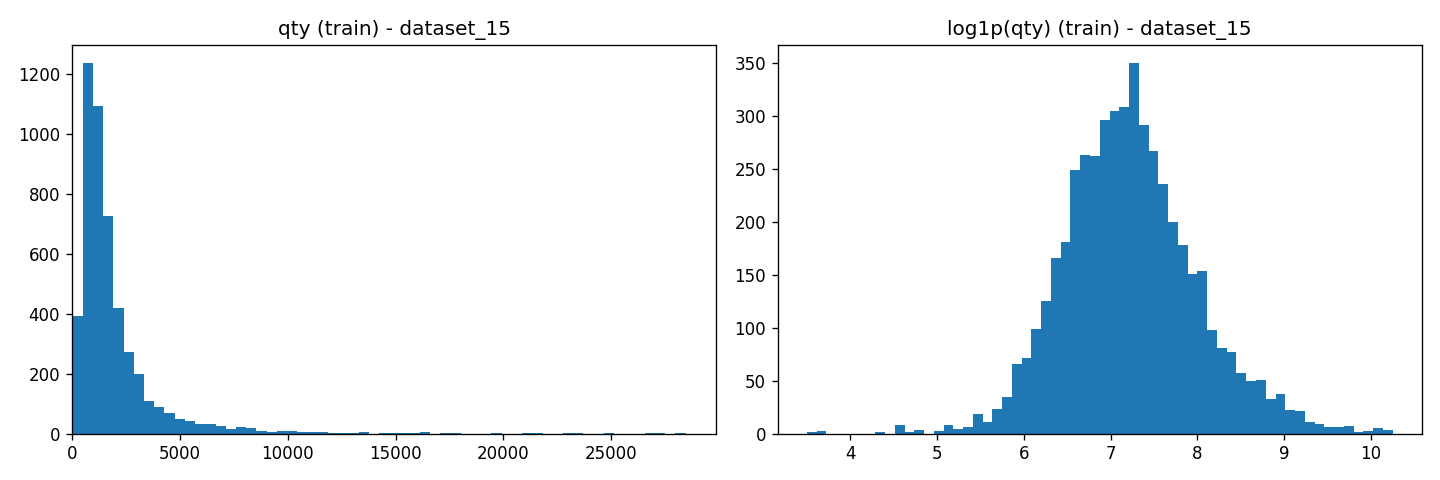


[dataset_15] zero ratio global: 0.0

[dataset_15] zero ratio per cabang (paling parah dulu)
rows: 9 | cols: 4
  cabang  zero_ratio     mean_qty  median_qty
0    02A         0.0  1269.543089       923.0
1    05A         0.0  1424.177236      1032.0
2    13A         0.0  2445.390244      1872.0
3    13I         0.0  2677.949593      1776.0
4    14A         0.0  1613.640650      1308.0
5    16C         0.0  2752.427642      1484.0
6    17A         0.0  1281.412195      1078.5
7    23A         0.0  2670.841463      2095.0
8    29A         0.0  1284.699187       898.0
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\zero_ratio_by_cabang_dataset_15.csv

[dataset_15] korelasi ke log_qty (ringkas)
log_qty               1.000000
qty                   0.813326
qty_lag12             0.496046
qty_lag11             0.474306
qty_lag3              0.446904
qty_lag2              0.440008
qty_lag10             0.381677
qty_lag1              0.267061
event_flag            0.231044
rainfall_lag1  

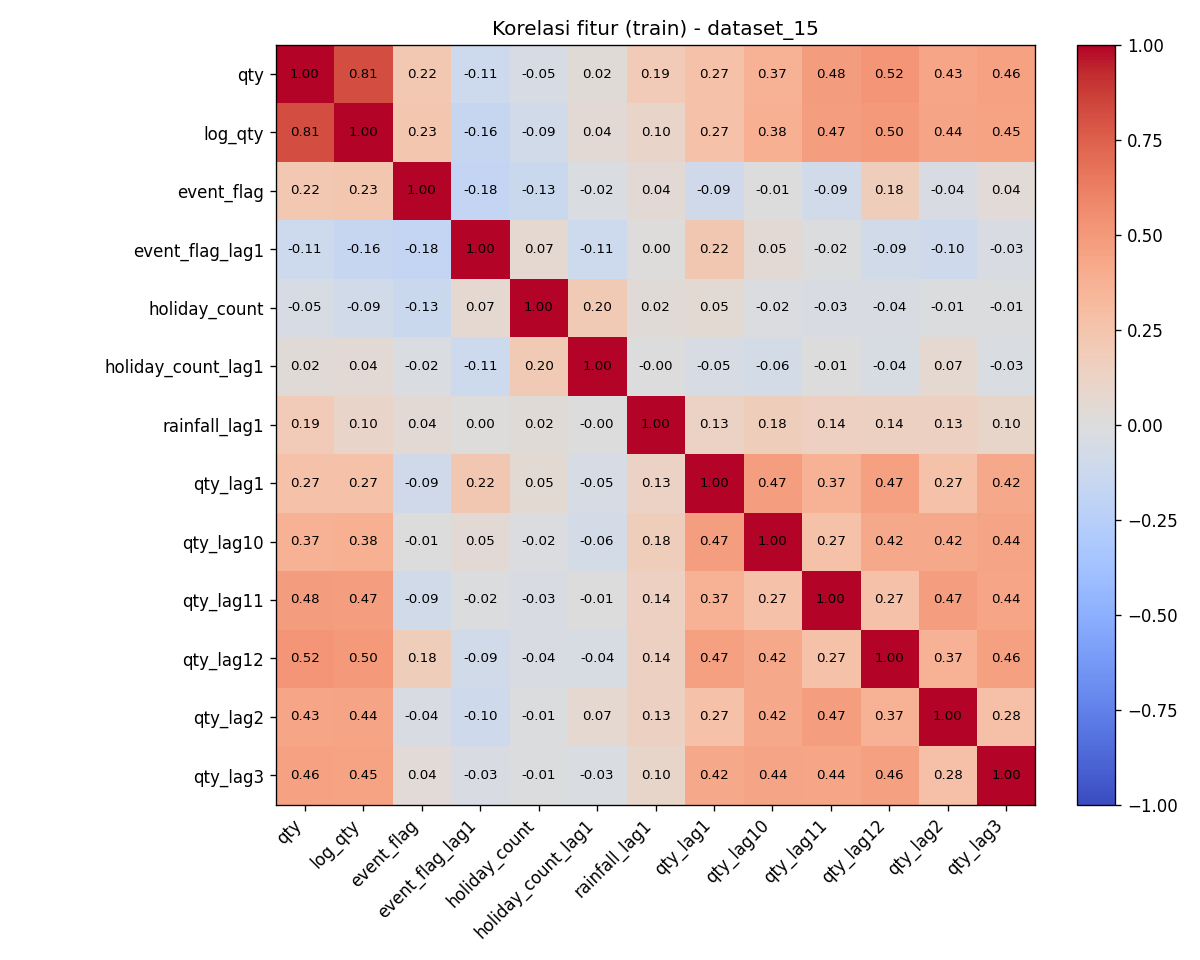

Saved: D:\Documents\Skripsi\demand-forecasting\outputs\corr_core_dataset_15.csv

[dataset_15] stationarity scan
seri dicek: 120
proporsi suggest_d=1: 0.48333333333333334

[dataset_15] contoh 10 hasil stationarity
rows: 120 | cols: 6
  cabang           sku  n_train    adf_pvalue  kpss_pvalue  suggest_d
0    02A   BNOP400CHAR       41  2.990337e-02     0.100000          0
1    02A   BNOP400CPOX       41  2.990337e-02     0.100000          0
2    02A   BUVW001K194       41  6.973887e-01     0.020555          1
3    02A    BUVW001KSB       41  3.668698e-12     0.100000          0
4    02A   BUVW001KSBM       41  2.356052e-12     0.081081          0
5    02A    BUVW001KSW       41  4.589288e-01     0.040904          1
6    02A   BUVW100C192       41  3.983390e-02     0.100000          0
7    02A    BUVW100CSB       41  2.876798e-05     0.012605          1
8    02A    BUVW100CSW       41  3.724049e-01     0.021507          1
9    02A  CKLM001KS607       41  1.690718e-12     0.046573         

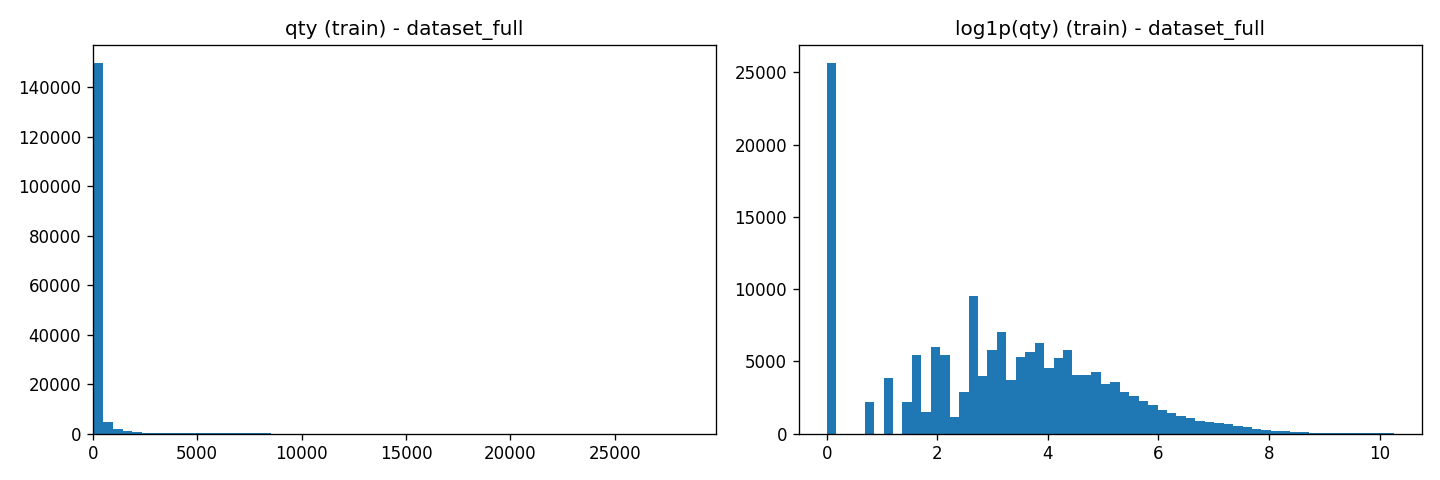


[dataset_full] zero ratio global: 0.16142012430495645

[dataset_full] zero ratio per cabang (paling parah dulu)
rows: 9 | cols: 4
  cabang  zero_ratio     mean_qty  median_qty
5    16C    0.380628   135.763777         8.0
8    29A    0.143680   103.510534        24.0
0    02A    0.122352   103.792149        24.0
4    14A    0.101125   126.327096        34.0
1    05A    0.098083    92.832509        24.0
3    13I    0.094525   142.167221        25.0
2    13A    0.000000  2445.390244      1872.0
6    17A    0.000000  1281.412195      1078.5
7    23A    0.000000  2670.841463      2095.0
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\zero_ratio_by_cabang_dataset_full.csv

[dataset_full] korelasi ke log_qty (ringkas)
log_qty               1.000000
qty                   0.456446
qty_lag2              0.405719
qty_lag3              0.401656
qty_lag1              0.389790
qty_lag11             0.387112
qty_lag12             0.386139
qty_lag10             0.382938
event_flag            

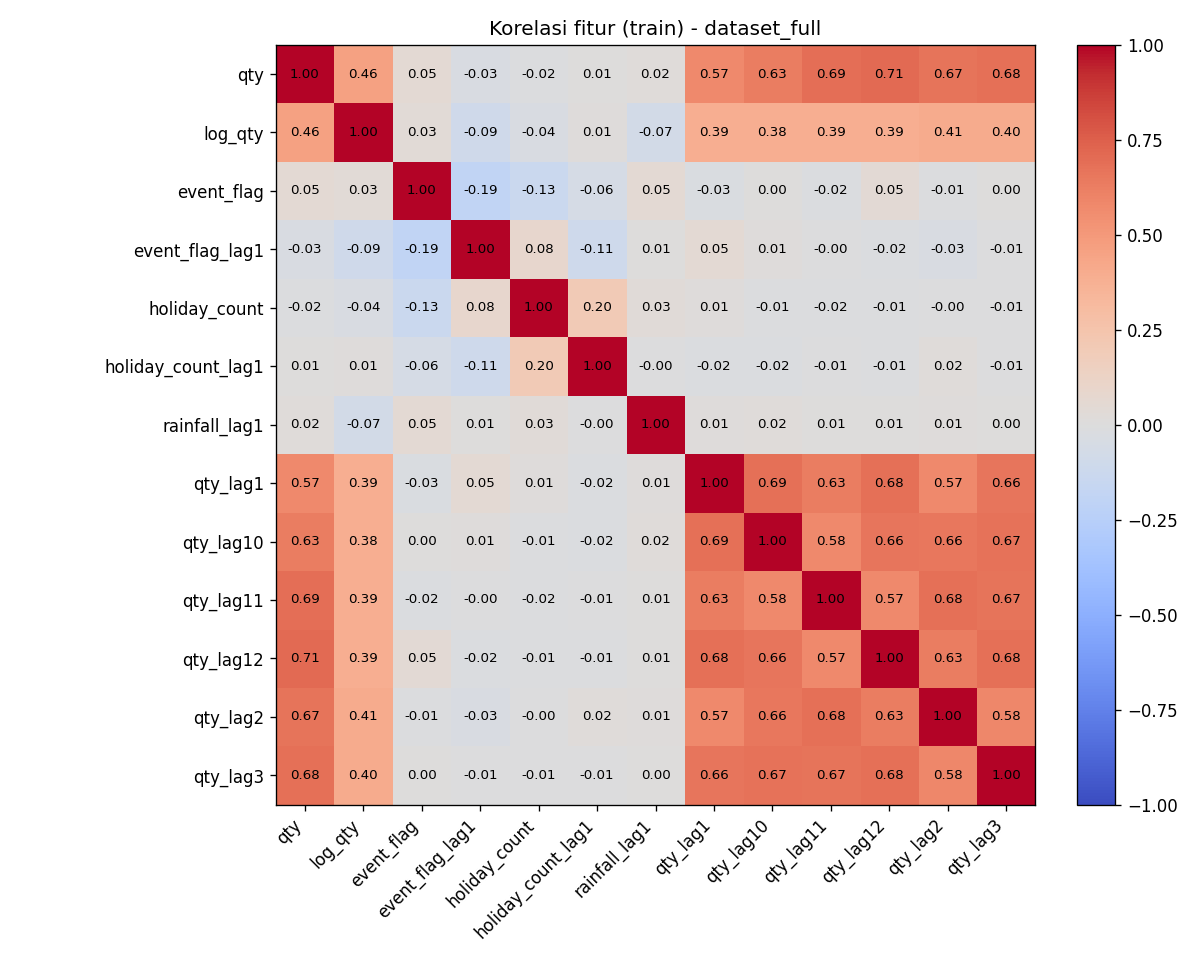

Saved: D:\Documents\Skripsi\demand-forecasting\outputs\corr_core_dataset_full.csv

[dataset_full] stationarity scan
seri dicek: 3890
proporsi suggest_d=1: 0.5537275064267352

[dataset_full] contoh 10 hasil stationarity
rows: 3890 | cols: 6
  cabang          sku  n_train    adf_pvalue  kpss_pvalue  suggest_d
0    02A  APQR005K102       41  8.173221e-15     0.100000          0
1    02A  APQR005K104       41  1.552175e-10     0.100000          0
2    02A  APQR005K405       40  2.739055e-07     0.100000          0
3    02A  APQR005K503       41  9.618764e-01     0.035389          1
4    02A  APQR005K504       41  8.871324e-05     0.082491          0
5    02A  APQR005K602       41  3.371761e-04     0.100000          0
6    02A  APQR005K603       41  1.785874e-08     0.100000          0
7    02A  APQR005K801       41  1.434727e-06     0.100000          0
8    02A   APQR005KBA       41  1.778739e-10     0.100000          0
9    02A   APQR005KBB       41  1.545014e-08     0.100000          0
S

In [33]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
from IPython.display import display, Image

# warning yang masuk akal: kompatibilitas + spam KPSS
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=InterpolationWarning)

pd.set_option("display.width", None)
pd.set_option("display.max_columns", 60)

SHOW_TOP = 12
SHOW_CABANG = 15
SHOW_PNG = True

def ensure_dir(path):
    path.parent.mkdir(parents=True, exist_ok=True)

def show_df(title, df, n=10):
    print(f"\n{title}")
    print("rows:", len(df), "| cols:", df.shape[1])
    if len(df) == 0:
        return
    print(df.head(n))

def show_png(path, title=None):
    if title:
        print(title)
    if SHOW_PNG:
        display(Image(filename=str(path)))

# ambil data dari CSV, bukan folder
def load_dataset(csv_path):
    df = pd.read_csv(csv_path, parse_dates=["periode"], low_memory=False)

    if "is_train" not in df.columns:
        df["is_train"] = 1
    if "is_test" not in df.columns:
        df["is_test"] = 0

    need = ["cabang", "sku", "periode", "qty", "is_train", "is_test"]
    miss = [c for c in need if c not in df.columns]
    if miss:
        raise ValueError(f"Kolom wajib hilang: {miss}")

    df["qty"] = pd.to_numeric(df["qty"], errors="coerce").fillna(0.0)
    return df

# buat lihat bentuk datanya dulu (skew, outlier, dll)
def plot_qty_distribution(df, tag):
    train = df.loc[df["is_train"] == 1].copy()
    if train.empty:
        print(f"[{tag}] train kosong, skip distribusi")
        return

    train["log_qty"] = np.log1p(train["qty"])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].hist(train["qty"], bins=60)
    ax[0].set_title(f"qty (train) - {tag}")
    ax[0].set_xlim(left=0)

    ax[1].hist(train["log_qty"], bins=60)
    ax[1].set_title(f"log1p(qty) (train) - {tag}")

    plt.tight_layout()

    out = OUT_DIR / f"dist_qty_{tag}.png"
    ensure_dir(out)
    fig.savefig(out, dpi=120)
    plt.close(fig)

    print(f"\n[{tag}] ringkasan qty (train)")
    print(train["qty"].describe())
    show_png(out, title=f"[{tag}] plot distribusi qty")

# buat lihat sparsity (banyak nol) per cabang
def compute_zero_ratio(df, tag):
    train = df.loc[df["is_train"] == 1].copy()
    if train.empty:
        print(f"[{tag}] train kosong, skip zero ratio")
        return

    zero_global = float((train["qty"] == 0).mean())

    by_cbg = (
        train.groupby("cabang", as_index=False)["qty"]
             .agg(
                 zero_ratio=lambda s: float((s == 0).mean()),
                 mean_qty=lambda s: float(s.mean()),
                 median_qty=lambda s: float(s.median()),
             )
             .sort_values("zero_ratio", ascending=False)
    )

    out_csv = OUT_DIR / f"zero_ratio_by_cabang_{tag}.csv"
    ensure_dir(out_csv)
    by_cbg.to_csv(out_csv, index=False)

    print(f"\n[{tag}] zero ratio global:", zero_global)
    show_df(f"[{tag}] zero ratio per cabang (paling parah dulu)", by_cbg, n=SHOW_CABANG)
    print("Saved:", out_csv)

# korelasi fitur inti, warna harus coolwarm -1..1
def compute_core_correlation(df, tag):
    train = df.loc[df["is_train"] == 1].copy()
    if train.empty:
        print(f"[{tag}] train kosong, skip korelasi")
        return

    train["log_qty"] = np.log1p(train["qty"])

    core_cols = [
        "qty", "log_qty",
        "event_flag", "event_flag_lag1",
        "holiday_count", "holiday_count_lag1",
        "rainfall_lag1",
    ]

    lag_cols = sorted([c for c in train.columns if c.startswith("qty_lag")])
    core_cols += lag_cols[:6]
    core_cols = [c for c in core_cols if c in train.columns]

    if len(core_cols) < 2:
        print(f"[{tag}] kolom korelasi kurang, skip")
        return

    corr = train[core_cols].corr(numeric_only=True)

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)

    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.index)))
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(corr.index)

    for i in range(len(corr.index)):
        for j in range(len(corr.columns)):
            ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center", fontsize=8)

    ax.set_title(f"Korelasi fitur (train) - {tag}")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()

    out_png = OUT_DIR / f"corr_heatmap_{tag}.png"
    ensure_dir(out_png)
    fig.savefig(out_png, dpi=120)
    plt.close(fig)

    out_csv = OUT_DIR / f"corr_core_{tag}.csv"
    ensure_dir(out_csv)
    corr.to_csv(out_csv)

    if "log_qty" in corr.columns:
        s = corr["log_qty"].dropna().sort_values(ascending=False)
        print(f"\n[{tag}] korelasi ke log_qty (ringkas)")
        print(s.head(SHOW_TOP))
        print("\n... yang paling negatif")
        print(s.tail(SHOW_TOP))

    show_png(out_png, title=f"[{tag}] heatmap korelasi")
    print("Saved:", out_csv)

# ADF + KPSS buat indikasi butuh differencing apa engga
def stationarity_scan(df, tag):
    train = df.loc[df["is_train"] == 1].copy()
    if train.empty:
        print(f"[{tag}] train kosong, skip stationarity")
        return

    rows = []
    for (cab, sku), g in train.groupby(["cabang", "sku"], sort=False):
        y = np.log1p(g["qty"].astype(float))
        if len(y) < 12:
            continue

        try:
            _, adf_p, *_ = adfuller(y, autolag="AIC")
        except Exception:
            adf_p = np.nan

        try:
            kpss_stat, kpss_p, *_ = kpss(y, nlags="auto")
        except Exception:
            kpss_p = np.nan

        adf_ok = (adf_p < 0.05) if pd.notna(adf_p) else False
        kpss_ok = (kpss_p > 0.05) if pd.notna(kpss_p) else False

        rows.append({
            "cabang": cab,
            "sku": sku,
            "n_train": int(len(y)),
            "adf_pvalue": float(adf_p) if pd.notna(adf_p) else np.nan,
            "kpss_pvalue": float(kpss_p) if pd.notna(kpss_p) else np.nan,
            "suggest_d": 0 if (adf_ok and kpss_ok) else 1,
        })

    res = pd.DataFrame(rows)

    out_csv = OUT_DIR / f"stationarity_{tag}.csv"
    ensure_dir(out_csv)
    res.to_csv(out_csv, index=False)

    print(f"\n[{tag}] stationarity scan")
    if len(res):
        print("seri dicek:", len(res))
        print("proporsi suggest_d=1:", float((res["suggest_d"] == 1).mean()))
        show_df(f"[{tag}] contoh 10 hasil stationarity", res, n=10)
    else:
        print("tidak ada seri yang cukup panjang (>=12 bulan train)")

    print("Saved:", out_csv)

# wrapper biar panggilnya 2x doang
def run_eda_for_dataset(csv_path, tag):
    print(f"\nRUN: {tag}")
    print("source:", csv_path)

    df = load_dataset(csv_path)

    print(f"[{tag}] periode:", df["periode"].min(), "->", df["periode"].max())
    print(f"[{tag}] unique cabang:", df["cabang"].nunique(), "| unique sku:", df["sku"].nunique())
    print(f"[{tag}] rows train:", int((df["is_train"] == 1).sum()), "| rows test:", int((df["is_test"] == 1).sum()))

    plot_qty_distribution(df, tag)
    compute_zero_ratio(df, tag)
    compute_core_correlation(df, tag)
    stationarity_scan(df, tag)

    print(f"Done: {tag}")

# ini bagian yang kamu isi sekali: file yang mau dianalisis
DS15_PATH   = DATASET15_DIR / "panel_exog_selected15.csv"
DSFULL_PATH = STD_DIR       / "panel_model_eligible_all.csv"

run_eda_for_dataset(DS15_PATH, "dataset_15")
run_eda_for_dataset(DSFULL_PATH, "dataset_full")


Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_summary\zero_ratio_by_cabang_15_vs_full.png
plot: zero ratio per cabang


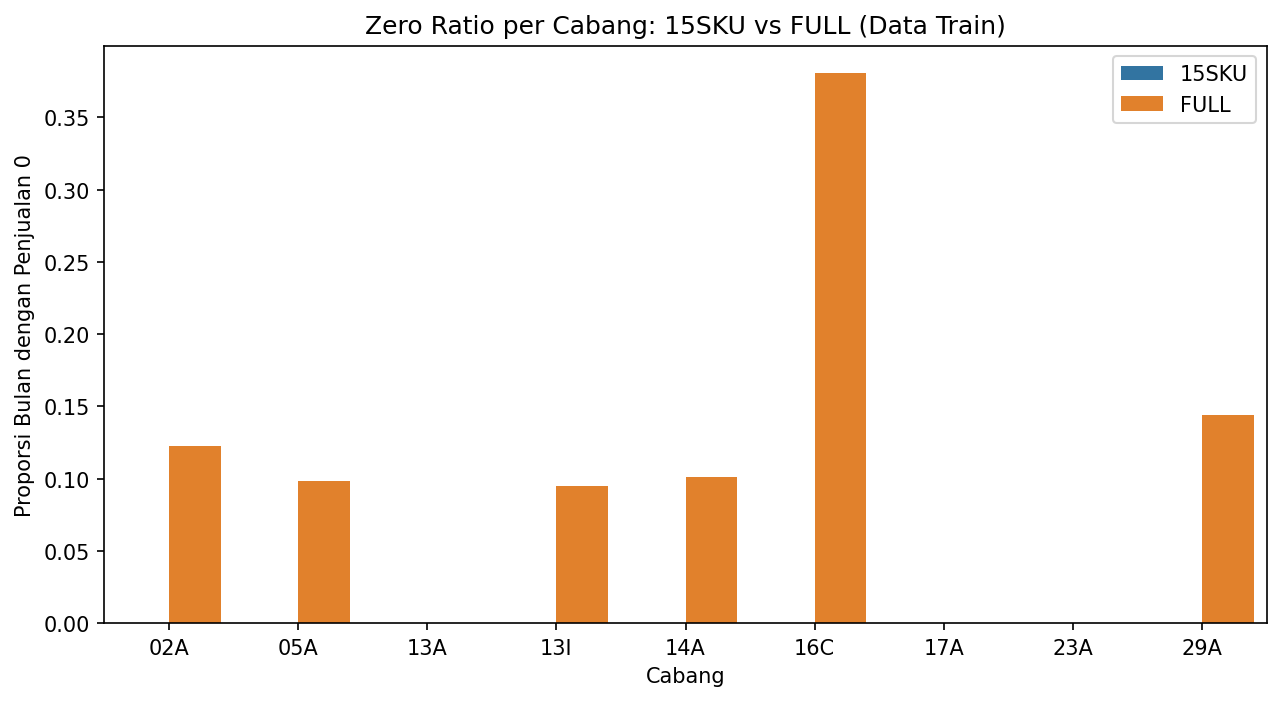

Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_summary\zero_ratio_per_series_boxplot_15_vs_full.png
plot: boxplot zero ratio per seri


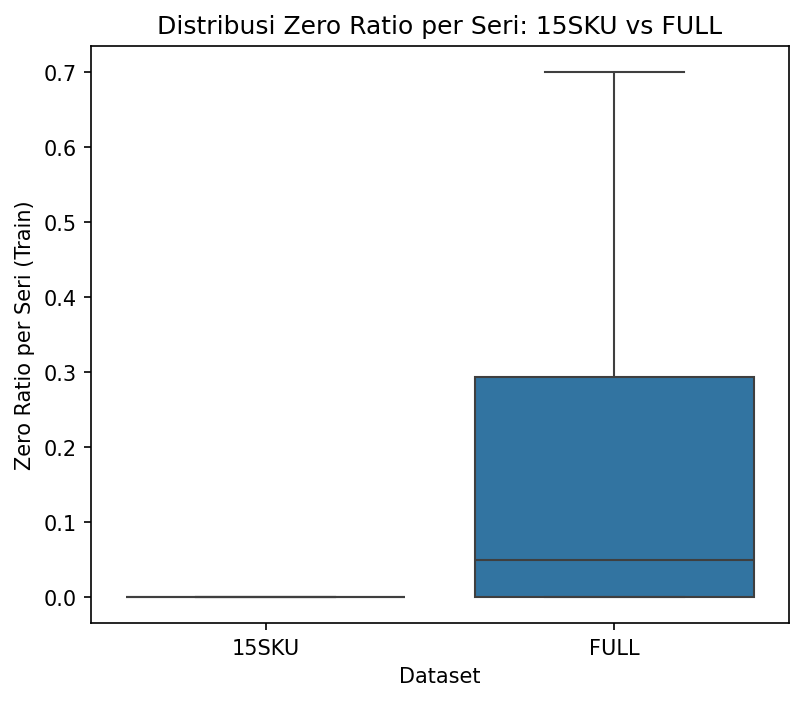

Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_summary\proporsi_suggest_d_15_vs_full.png
plot: proporsi suggest_d


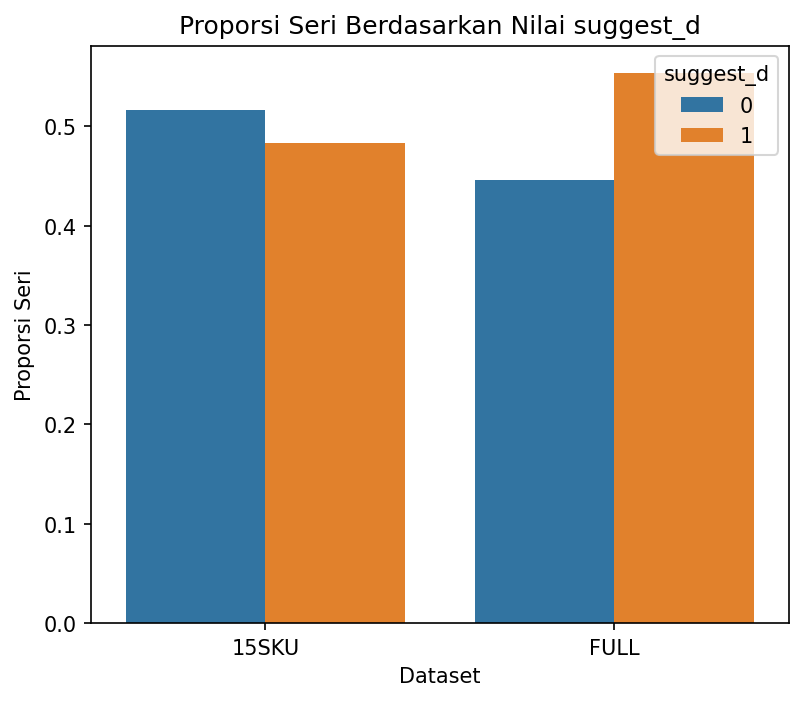

Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_summary\stationarity_summary_15_vs_full.csv


,dataset,n_seri,adf_stationary,kpss_stationary
0,15SKU,49,0.741667,0.566667
1,FULL,1035,0.689203,0.572494


In [38]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Image

PROJECT_ROOT = Path(r"D:\Documents\Skripsi\demand-forecasting")
EDA_OUT  = PROJECT_ROOT / "outputs" / "eda_modeling"
PLOT_OUT = PROJECT_ROOT / "outputs" / "eda_summary"
PLOT_OUT.mkdir(parents=True, exist_ok=True)

SHOW_PNG = True


def must_exist(p: Path):
    if not p.exists():
        raise FileNotFoundError(f"File tidak ketemu: {p}")


def save_and_show(fig, out_path: Path, title=None, dpi=150):
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", out_path)
    if SHOW_PNG:
        if title:
            print(title)
        display(Image(filename=str(out_path)))


# ngambil hasil zero ratio per cabang dari EDA (buat bandingin 15SKU vs FULL)
zr15_path   = EDA_OUT / "zero_ratio_by_cabang_dataset_15SKU.csv"
zrfull_path = EDA_OUT / "zero_ratio_by_cabang_dataset_FULL.csv"
must_exist(zr15_path)
must_exist(zrfull_path)

zr_15   = pd.read_csv(zr15_path)
zr_full = pd.read_csv(zrfull_path)

zr_15["dataset"] = "15SKU"
zr_full["dataset"] = "FULL"
zr_all = pd.concat([zr_15, zr_full], ignore_index=True)

# beresin urutan cabang biar plotnya konsisten (nggak loncat-loncat)
zr_all["cabang"] = zr_all["cabang"].astype(str)
order_cabang = sorted(zr_all["cabang"].unique())
zr_all["cabang"] = pd.Categorical(zr_all["cabang"], categories=order_cabang, ordered=True)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
sns.barplot(data=zr_all, x="cabang", y="zero_ratio", hue="dataset", ax=ax)
ax.set_title("Zero Ratio per Cabang: 15SKU vs FULL (Data Train)")
ax.set_xlabel("Cabang")
ax.set_ylabel("Proporsi Bulan dengan Penjualan 0")
ax.legend(title="")

out = PLOT_OUT / "zero_ratio_by_cabang_15_vs_full.png"
save_and_show(fig, out, title="plot: zero ratio per cabang")


# ngambil health per seri (buat liat sebaran zero_ratio per cabang-SKU)
h15_path   = EDA_OUT / "health_sku_dataset_15SKU.csv"
hfull_path = EDA_OUT / "health_sku_dataset_FULL.csv"
must_exist(h15_path)
must_exist(hfull_path)

health_15   = pd.read_csv(h15_path)
health_full = pd.read_csv(hfull_path)

health_15["dataset"] = "15SKU"
health_full["dataset"] = "FULL"
health_all = pd.concat([health_15, health_full], ignore_index=True)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
sns.boxplot(data=health_all, x="dataset", y="zero_ratio", ax=ax)
ax.set_title("Distribusi Zero Ratio per Seri: 15SKU vs FULL")
ax.set_xlabel("Dataset")
ax.set_ylabel("Zero Ratio per Seri (Train)")

out = PLOT_OUT / "zero_ratio_per_series_boxplot_15_vs_full.png"
save_and_show(fig, out, title="plot: boxplot zero ratio per seri")


# ngambil hasil stationarity (ADF+KPSS + suggest_d) buat ringkasan differencing
st15_path   = EDA_OUT / "stationarity_dataset_15SKU.csv"
stfull_path = EDA_OUT / "stationarity_dataset_FULL.csv"
must_exist(st15_path)
must_exist(stfull_path)

stat_15   = pd.read_csv(st15_path)
stat_full = pd.read_csv(stfull_path)

stat_15["dataset"] = "15SKU"
stat_full["dataset"] = "FULL"
stat_all = pd.concat([stat_15, stat_full], ignore_index=True)

# kalau CSV yang kebaca cuma p-value, bikin flag stationarity sendiri biar summary tetap jalan
if "adf_stationary" not in stat_all.columns and "adf_pvalue" in stat_all.columns:
    stat_all["adf_stationary"] = (pd.to_numeric(stat_all["adf_pvalue"], errors="coerce") < 0.05).astype(int)

if "kpss_stationary" not in stat_all.columns and "kpss_pvalue" in stat_all.columns:
    stat_all["kpss_stationary"] = (pd.to_numeric(stat_all["kpss_pvalue"], errors="coerce") > 0.05).astype(int)

# hitung proporsi suggest_d per dataset (d=0 vs d=1)
prop_d = (
    stat_all.groupby(["dataset", "suggest_d"])
            .size()
            .reset_index(name="n_seri")
)

prop_d["proporsi"] = prop_d["n_seri"] / prop_d.groupby("dataset")["n_seri"].transform("sum")

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
sns.barplot(data=prop_d, x="dataset", y="proporsi", hue="suggest_d", ax=ax)
ax.set_title("Proporsi Seri Berdasarkan Nilai suggest_d")
ax.set_xlabel("Dataset")
ax.set_ylabel("Proporsi Seri")
ax.legend(title="suggest_d")

out = PLOT_OUT / "proporsi_suggest_d_15_vs_full.png"
save_and_show(fig, out, title="plot: proporsi suggest_d")


# bikin CSV ringkasan stationarity biar gampang masuk bab pembahasan
if {"adf_stationary", "kpss_stationary"}.issubset(stat_all.columns):
    summary_stat = (
        stat_all.groupby("dataset", as_index=False)
                .agg(
                    n_seri=("sku", "nunique"),
                    adf_stationary=("adf_stationary", "mean"),
                    kpss_stationary=("kpss_stationary", "mean"),
                )
    )

    summary_path = PLOT_OUT / "stationarity_summary_15_vs_full.csv"
    summary_stat.to_csv(summary_path, index=False)
    print("Saved:", summary_path)
    display(summary_stat)
else:
    print("Kolom stationarity belum ada dan p-value juga tidak ada, jadi summary diskip.")


In [39]:
panel15 = pd.read_csv(
    DATASET15_DIR / "panel_exog_selected15.csv",
    parse_dates=["periode"]
)
print("Panel 15 shape:", panel15.shape)


Panel 15 shape: (4965, 43)


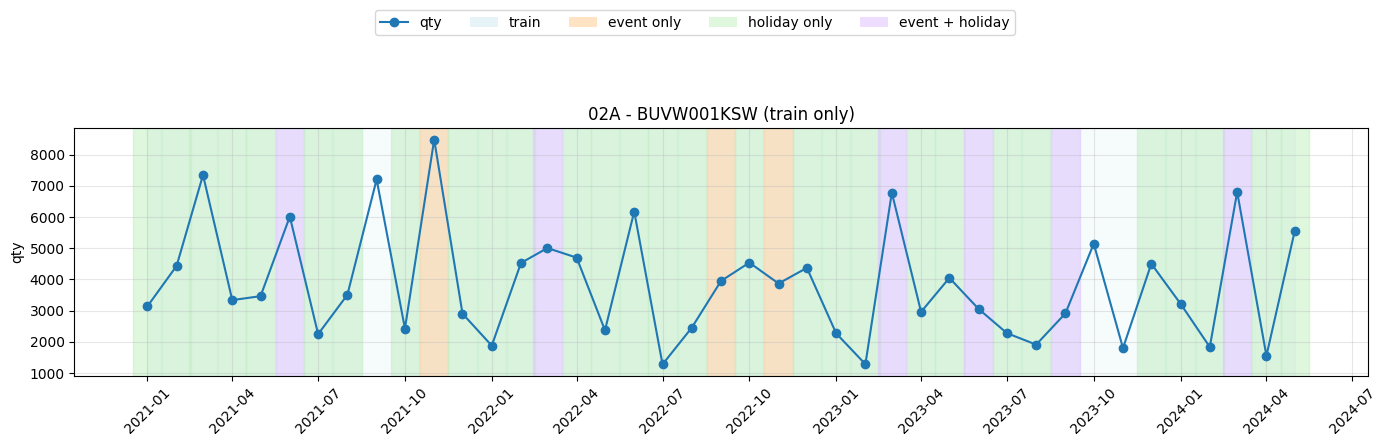

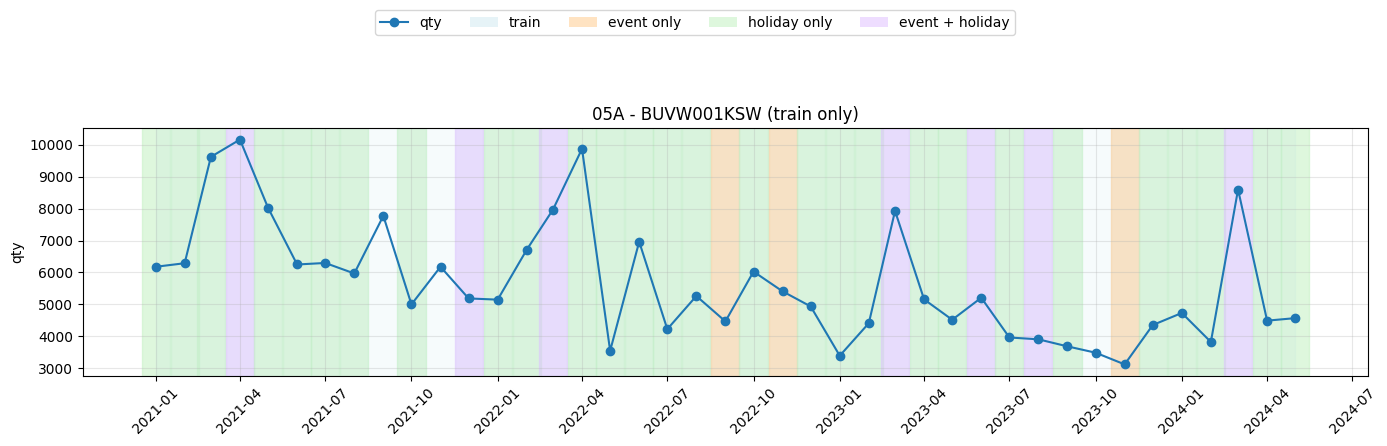

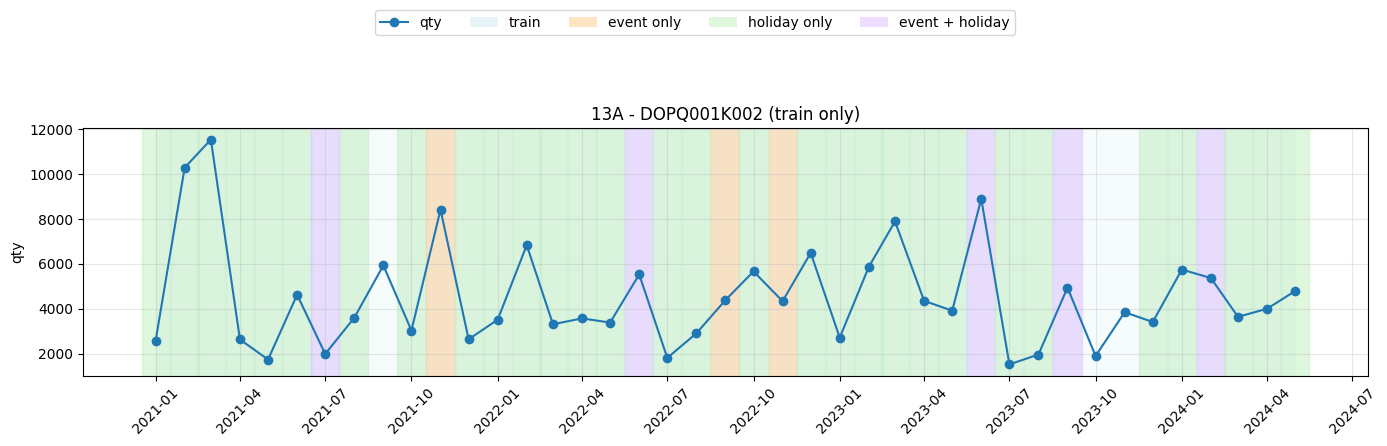

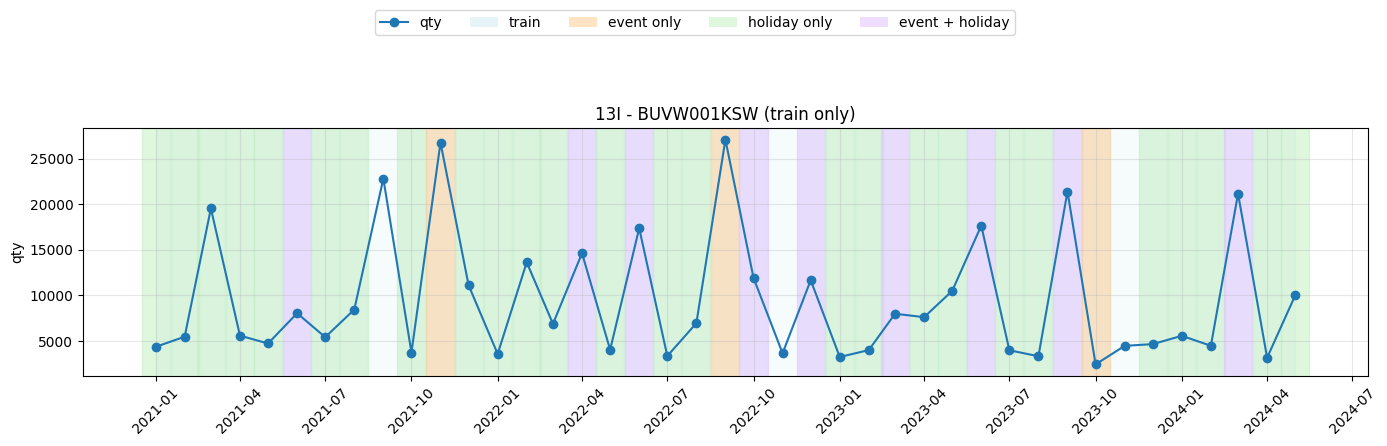

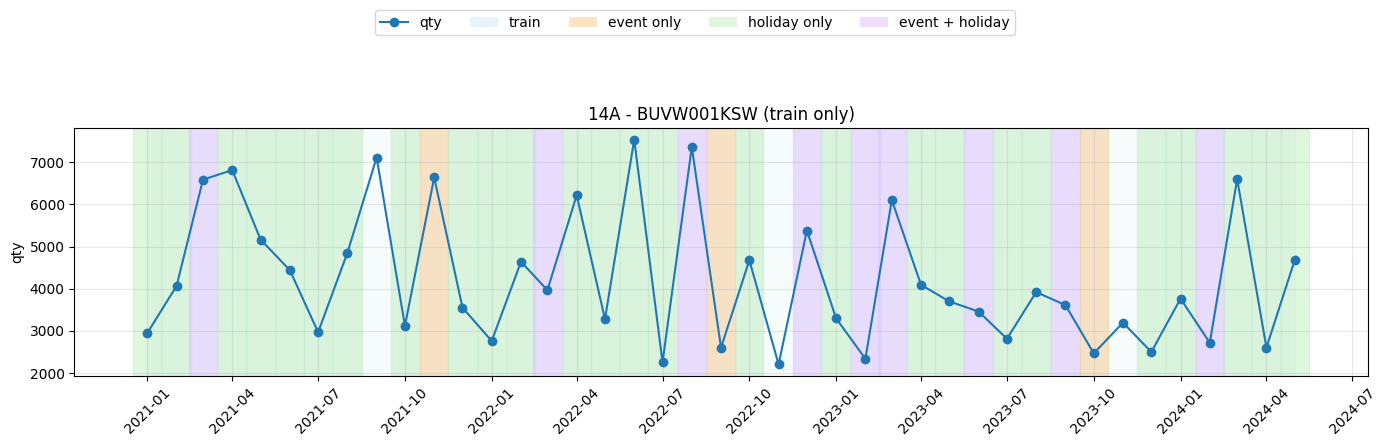

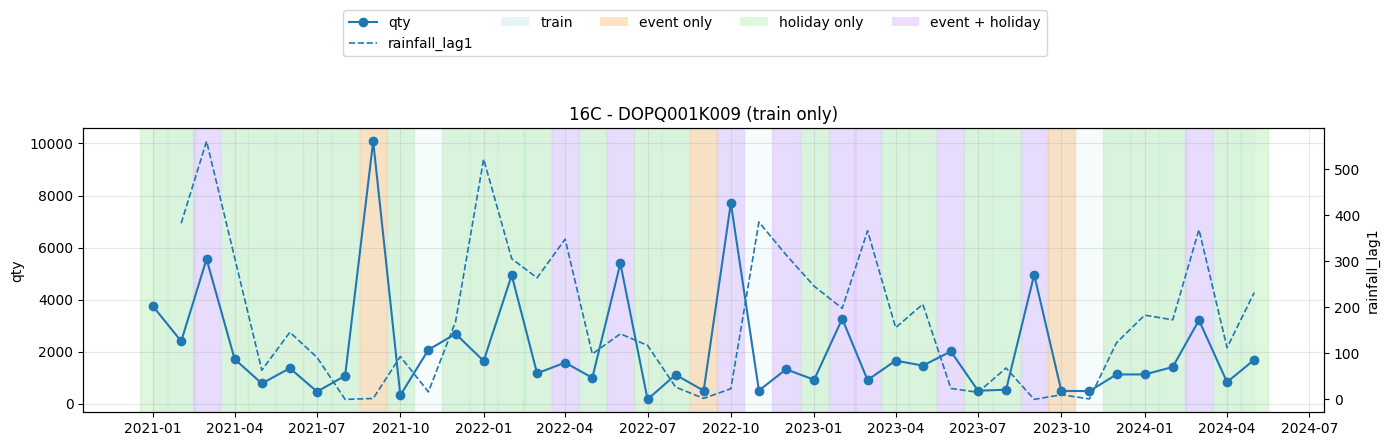

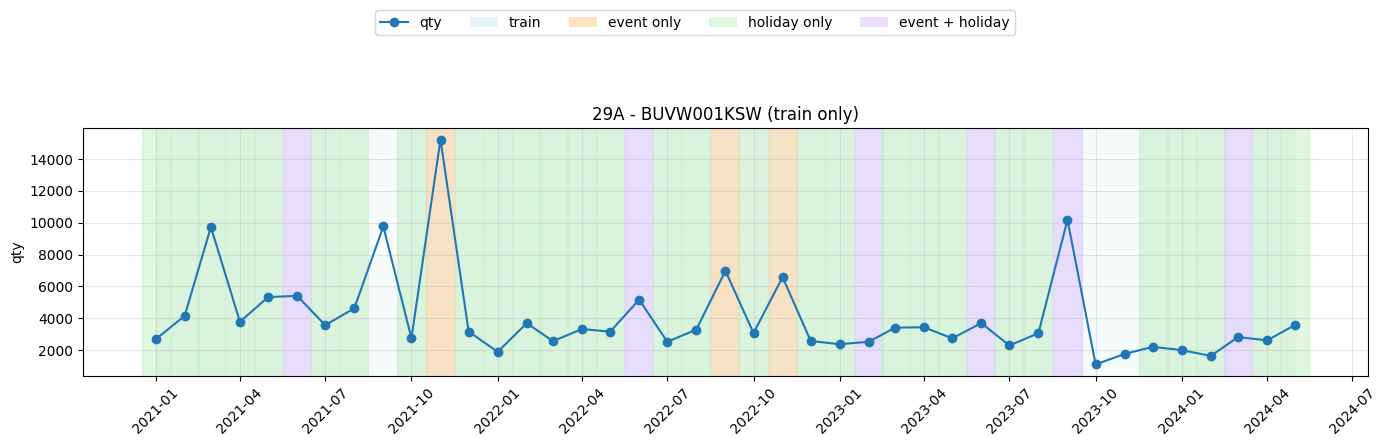

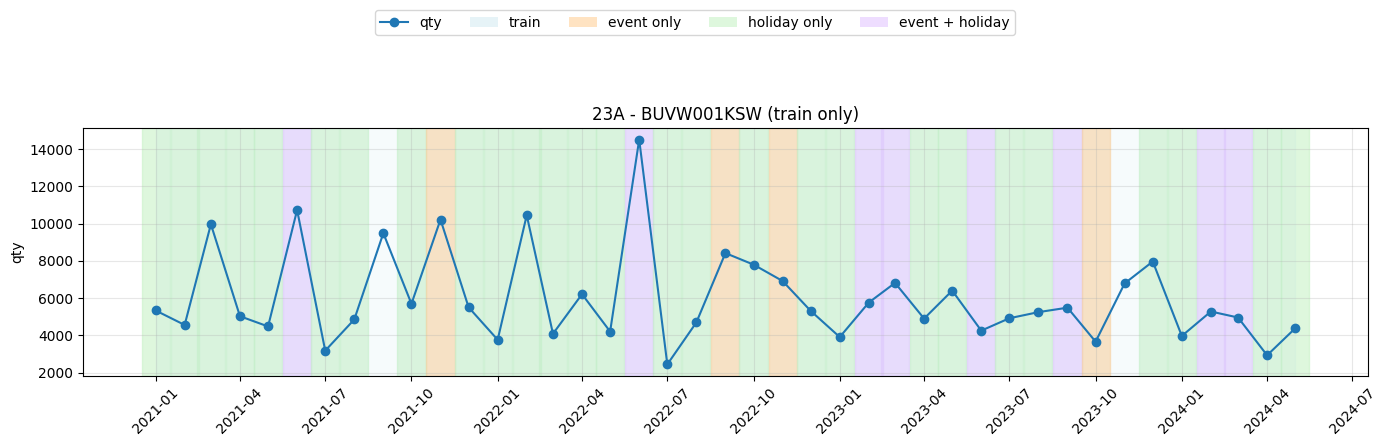

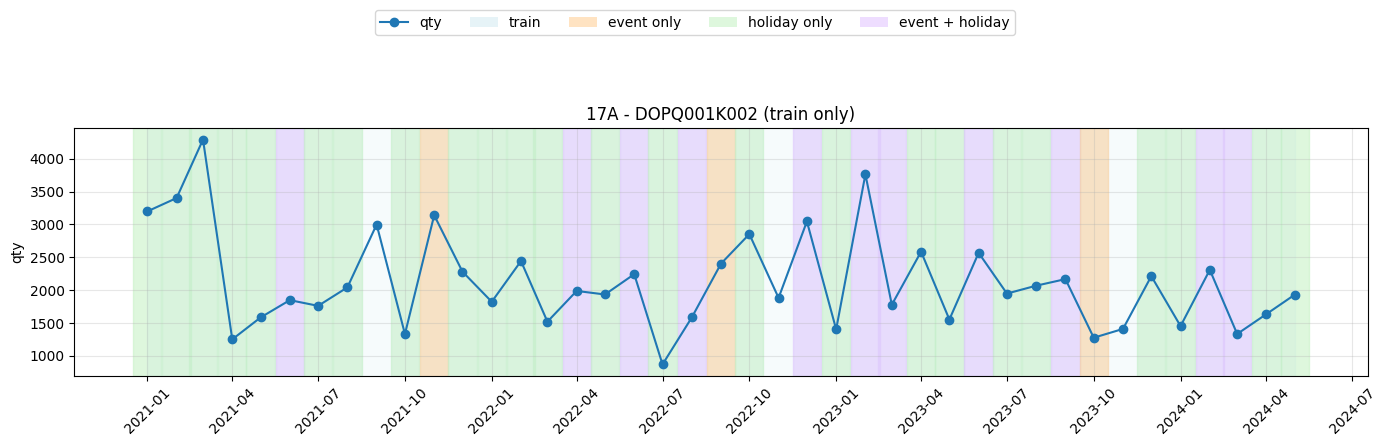

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch


# daftar 9 seri yang mau diplot
selected_9 = pd.DataFrame(
    [
        {"cabang": "02A", "sku": "BUVW001KSW"},
        {"cabang": "05A", "sku": "BUVW001KSW"},
        {"cabang": "13A", "sku": "DOPQ001K002"},
        {"cabang": "13I", "sku": "BUVW001KSW"},
        {"cabang": "14A", "sku": "BUVW001KSW"},
        {"cabang": "16C", "sku": "DOPQ001K009"},
        {"cabang": "29A", "sku": "BUVW001KSW"},
        {"cabang": "23A", "sku": "BUVW001KSW"},
        {"cabang": "17A", "sku": "DOPQ001K002"},
    ]
)


# plot 1 seri: qty + blok event/holiday, train saja
def plot_series_train_only(df, cabang, sku):
    train_end = pd.Timestamp("2024-05-01")

    g = (
        df[(df["cabang"] == cabang) & (df["sku"] == sku)]
        .sort_values("periode")
        .copy()
    )

    # filter train saja (kalau ada flag, pakai flag. kalau tidak, pakai cutoff tanggal)
    if "is_train" in g.columns:
        g = g[g["is_train"] == 1]
    else:
        g = g[g["periode"] <= train_end]

    if g.empty:
        print(f"Skip {cabang}-{sku} (data kosong)")
        return

    fig, ax = plt.subplots(figsize=(14, 4))

    # shading background train
    ax.axvspan(
        g["periode"].min(),
        g["periode"].max(),
        color="lightblue",
        alpha=0.10,
        label="train"
    )

    # blok event/holiday per bulan
    half_month = pd.Timedelta(days=15)

    ex = (
        g[["periode", "event_flag", "holiday_count"]]
        .drop_duplicates("periode")
        .copy()
    )

    ex["event_flag"] = (ex["event_flag"] > 0).astype(int)
    ex["holiday_flag"] = (ex["holiday_count"] > 0).astype(int)

    for _, r in ex.iterrows():
        if r["event_flag"] == 0 and r["holiday_flag"] == 0:
            continue

        if r["event_flag"] == 1 and r["holiday_flag"] == 0:
            color = "#FFD19A"   # event saja
        elif r["event_flag"] == 0 and r["holiday_flag"] == 1:
            color = "#C9F2C7"   # holiday saja
        else:
            color = "#E4C7FF"   # event + holiday

        ax.axvspan(
            r["periode"] - half_month,
            r["periode"] + half_month,
            color=color,
            alpha=0.6,
            zorder=0.5
        )

    # garis qty
    line_qty, = ax.plot(
        g["periode"],
        g["qty"],
        marker="o",
        linewidth=1.5,
        label="qty",
        zorder=2
    )

    ax.set_ylabel("qty")
    ax.set_title(f"{cabang} - {sku} (train only)")

    handles = [line_qty]
    labels = ["qty"]

    # rainfall khusus 16C (kalau kolom ada)
    if cabang == "16C" and "rainfall_lag1" in g.columns:
        ax2 = ax.twinx()
        line_rf, = ax2.plot(
            g["periode"],
            g["rainfall_lag1"],
            linestyle="--",
            linewidth=1.2,
            label="rainfall_lag1",
            zorder=1.5
        )
        ax2.set_ylabel("rainfall_lag1")
        handles.append(line_rf)
        labels.append("rainfall_lag1")

    # format sumbu waktu
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45)

    # legend blok warna
    legend_patches = [
        Patch(facecolor="lightblue", alpha=0.3, label="train"),
        Patch(facecolor="#FFD19A", alpha=0.6, label="event only"),
        Patch(facecolor="#C9F2C7", alpha=0.6, label="holiday only"),
        Patch(facecolor="#E4C7FF", alpha=0.6, label="event + holiday"),
    ]

    fig.legend(
        handles + legend_patches,
        labels + ["train", "event only", "holiday only", "event + holiday"],
        loc="upper center",
        bbox_to_anchor=(0.5, 1.12),
        ncol=5,
        frameon=True
    )

    plt.tight_layout(rect=(0, 0, 1, 0.90))
    plt.show()


# jalanin semua seri dari list selected_9
for _, row in selected_9.iterrows():
    plot_series_train_only(panel15, row["cabang"], row["sku"])


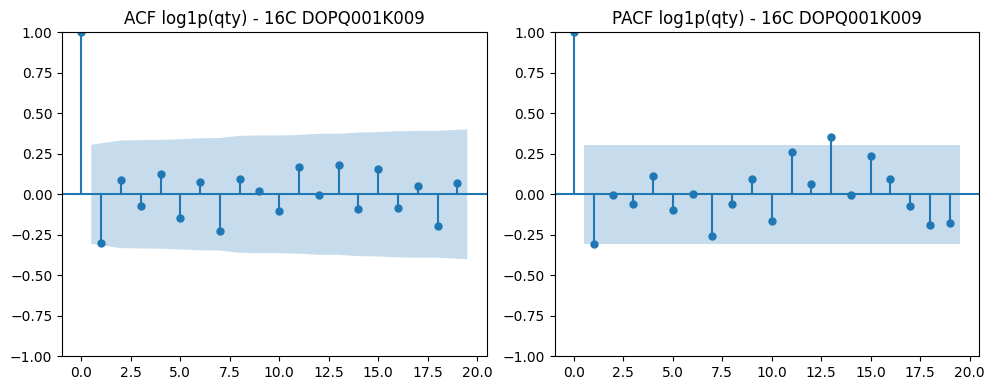


ADF log1p(qty)
  stat   : -8.530676906907818
  p-value: 1.039753814403554e-13

KPSS log1p(qty)
  stat   : 0.2680306108302164
  p-value: 0.1


In [45]:
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

cab_exam = "16C"
sku_exam = "DOPQ001K009"

g = (
    panel15[(panel15["cabang"] == cab_exam) &
            (panel15["sku"] == sku_exam)]
    .sort_values("periode")
)

g_train = g[g["is_train"] == 1].copy()
y = np.log1p(g_train["qty"])

n = len(y)
max_lag = min(24, n // 2 - 1)

# cek pola lag di data train (buat feeling AR/MA + indikasi musiman)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(y, ax=axes[0], lags=max_lag)
plot_pacf(y, ax=axes[1], lags=max_lag, method="yw")
axes[0].set_title(f"ACF log1p(qty) - {cab_exam} {sku_exam}")
axes[1].set_title(f"PACF log1p(qty) - {cab_exam} {sku_exam}")
plt.tight_layout()
plt.show()

# uji stasioneritas buat log1p(qty) (ADF vs KPSS), warning KPSS disenyapin biar output ga berisik
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=InterpolationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    adf_res = adfuller(y, autolag="AIC")
    kpss_res = kpss(y, nlags="auto")

print("\nADF log1p(qty)")
print("  stat   :", adf_res[0])
print("  p-value:", adf_res[1])

print("\nKPSS log1p(qty)")
print("  stat   :", kpss_res[0])
print("  p-value:", kpss_res[1])


Buat modeling

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller, acf


# setup path utama project
PROJECT_ROOT     = Path(r"D:\Documents\Skripsi\demand-forecasting")
STD_DIR          = PROJECT_ROOT / "data" / "standardized"
DATASET15_DIR    = PROJECT_ROOT / "data" / "dataset_15"
DATASETFULL_DIR  = PROJECT_ROOT / "data" / "dataset_full"

panel_full_path  = STD_DIR       / "panel_model_eligible_all.csv"
panel15_path     = DATASET15_DIR / "panel_exog_selected15.csv"


# load panel data
panel_full = pd.read_csv(panel_full_path, parse_dates=["periode"])
panel15    = pd.read_csv(panel15_path,    parse_dates=["periode"])

print("panel_full rows:", len(panel_full))
print("panel15 rows    :", len(panel15))


# helper buat ADF p-value yang aman
def safe_adf_pvalue(y):
    y = pd.to_numeric(y, errors="coerce").dropna()
    if len(y) < 12:
        return np.nan
    try:
        return float(adfuller(y, autolag="AIC")[1])
    except Exception:
        return np.nan


# helper ambil nilai ACF di lag penting
def safe_acf_vals(y, nlags=24):
    y = pd.to_numeric(y, errors="coerce").dropna()
    if len(y) <= 2:
        return {}

    try:
        acf_vals = acf(
            y,
            nlags=min(nlags, len(y) - 2),
            fft=False,
            missing="conservative"
        )

        out = {}
        for L in [1, 2, 3, 6, 12]:
            out[f"acf_lag{L}"] = float(acf_vals[L]) if L < len(acf_vals) else np.nan
        return out

    except Exception:
        return {}


# bucket skala penjualan
def profile_bucket_scale(m):
    if m < 5:
        return "low"
    elif m < 50:
        return "medium"
    else:
        return "high"


# bucket sparsity
def profile_bucket_zero(z):
    if z <= 0.2:
        return "dense"
    elif z <= 0.5:
        return "semi_sparse"
    else:
        return "sparse"


# bangun profil model per cabang–SKU
def build_model_profiles(df: pd.DataFrame, label: str):
    df_tr = (
        df.query("is_train == 1")
          .sort_values(["cabang", "sku", "periode"])
          .copy()
    )

    rows = []

    for (cab, sku), g in df_tr.groupby(["cabang", "sku"], sort=False):
        g = g.sort_values("periode")
        y = g["qty"].astype(float)

        n_train    = len(g)
        zero_ratio = float((y == 0).mean())
        qty_mean   = float(y.mean())
        qty_median = float(y.median())
        qty_std    = float(y.std(ddof=1))
        qty_max    = float(y.max())

        spike_ratio = (
            float(g["spike_flag"].mean())
            if "spike_flag" in g.columns else np.nan
        )

        # cek stasioner level vs differencing
        adf_level = safe_adf_pvalue(y)
        adf_diff1 = safe_adf_pvalue(y.diff())

        # cek struktur korelasi
        acf_dict = safe_acf_vals(y, nlags=24)
        acf1  = acf_dict.get("acf_lag1", np.nan)
        acf12 = acf_dict.get("acf_lag12", np.nan)

        seasonal_flag = int(
            not np.isnan(acf12) and abs(acf12) >= 0.3
        )

        # saran differencing SARIMAX
        if np.isnan(adf_level) or np.isnan(adf_diff1):
            d_sug = 1
        elif adf_level > 0.05 and adf_diff1 <= 0.05:
            d_sug = 1
        else:
            d_sug = 0

        D_sug = 1 if seasonal_flag == 1 else 0

        if not np.isnan(acf1) and abs(acf1) >= 0.5:
            sarimax_family = "AR_dominant"
        elif not np.isnan(acf1) and abs(acf1) <= 0.2:
            sarimax_family = "MA_or_low_AR"
        else:
            sarimax_family = "mixed"

        # skala model LGBM
        if n_train < 24:
            lgbm_size = "tiny"
            lgbm_max_depth = 4
            lgbm_num_leaves = 8
            lgbm_min_data_in_leaf = 5
        elif n_train < 48:
            lgbm_size = "small"
            lgbm_max_depth = 5
            lgbm_num_leaves = 16
            lgbm_min_data_in_leaf = 10
        elif n_train < 96:
            lgbm_size = "medium"
            lgbm_max_depth = 7
            lgbm_num_leaves = 32
            lgbm_min_data_in_leaf = 20
        else:
            lgbm_size = "large"
            lgbm_max_depth = 9
            lgbm_num_leaves = 64
            lgbm_min_data_in_leaf = 30

        if zero_ratio > 0.5:
            lgbm_min_data_in_leaf += 10
        if zero_ratio < 0.2 and qty_max > 200:
            lgbm_max_depth += 1

        # kelayakan TFT
        if n_train < 24 or zero_ratio > 0.7:
            tft_use = 0
            tft_encoder_len = np.nan
            tft_hidden_size = np.nan
        else:
            tft_use = 1
            tft_encoder_len = int(min(24, max(12, n_train - 6)))
            if qty_median < 5:
                tft_hidden_size = 8
            elif qty_median < 50:
                tft_hidden_size = 16
            else:
                tft_hidden_size = 32

        rows.append({
            "cabang": cab,
            "sku": sku,
            "dataset_label": label,

            "n_train": n_train,
            "zero_ratio": zero_ratio,
            "zero_bucket": profile_bucket_zero(zero_ratio),

            "qty_median": qty_median,
            "scale_bucket": profile_bucket_scale(qty_median),

            "qty_mean": qty_mean,
            "qty_std": qty_std,
            "qty_max": qty_max,
            "spike_ratio": spike_ratio,

            "adf_level_p": adf_level,
            "adf_diff1_p": adf_diff1,

            "acf_lag1": acf_dict.get("acf_lag1", np.nan),
            "acf_lag2": acf_dict.get("acf_lag2", np.nan),
            "acf_lag3": acf_dict.get("acf_lag3", np.nan),
            "acf_lag6": acf_dict.get("acf_lag6", np.nan),
            "acf_lag12": acf12,
            "seasonal_flag": seasonal_flag,

            "sarimax_d_sug": d_sug,
            "sarimax_D_sug": D_sug,
            "sarimax_family": sarimax_family,

            "lgbm_size_bucket": lgbm_size,
            "lgbm_max_depth_sug": lgbm_max_depth,
            "lgbm_num_leaves_sug": lgbm_num_leaves,
            "lgbm_min_data_in_leaf_sug": lgbm_min_data_in_leaf,

            "tft_use": tft_use,
            "tft_encoder_length_sug": tft_encoder_len,
            "tft_hidden_size_sug": tft_hidden_size,
        })

    return pd.DataFrame(rows)


# profiling untuk dataset full
profiles_full = build_model_profiles(panel_full, label="full")
profiles_full_path = DATASETFULL_DIR / "model_profiles_full.csv"
profiles_full.to_csv(profiles_full_path, index=False)
print("Saved model_profiles_full:", profiles_full_path)

summary_full_cbg = (
    profiles_full
    .groupby("cabang", as_index=False)
    .agg(
        n_sku=("sku","nunique"),
        median_zero_ratio=("zero_ratio","median"),
        median_n_train=("n_train","median"),
        frac_seasonal=("seasonal_flag","mean"),
        frac_tft_use=("tft_use","mean"),
        median_lgbm_max_depth=("lgbm_max_depth_sug","median"),
        median_lgbm_min_data_in_leaf=("lgbm_min_data_in_leaf_sug","median"),
    )
)

summary_full_path = DATASETFULL_DIR / "model_profiles_full_by_cabang.csv"
summary_full_cbg.to_csv(summary_full_path, index=False)
print("Saved model_profiles_full_by_cabang:", summary_full_path)


# profiling untuk dataset 15 SKU
profiles_15 = build_model_profiles(panel15, label="selected15")
profiles_15_path = DATASET15_DIR / "model_profiles_selected15.csv"
profiles_15.to_csv(profiles_15_path, index=False)
print("Saved model_profiles_selected15:", profiles_15_path)

summary_15_cbg = (
    profiles_15
    .groupby("cabang", as_index=False)
    .agg(
        n_sku=("sku","nunique"),
        median_zero_ratio=("zero_ratio","median"),
        median_n_train=("n_train","median"),
        frac_seasonal=("seasonal_flag","mean"),
        frac_tft_use=("tft_use","mean"),
        median_lgbm_max_depth=("lgbm_max_depth_sug","median"),
        median_lgbm_min_data_in_leaf=("lgbm_min_data_in_leaf_sug","median"),
    )
)

summary_15_path = DATASET15_DIR / "model_profiles_selected15_by_cabang.csv"
summary_15_cbg.to_csv(summary_15_path, index=False)
print("Saved model_profiles_selected15_by_cabang:", summary_15_path)


panel_full rows: 158863
panel15 rows    : 4965
Saved model_profiles_full: D:\Documents\Skripsi\demand-forecasting\data\dataset_full\model_profiles_full.csv
Saved model_profiles_full_by_cabang: D:\Documents\Skripsi\demand-forecasting\data\dataset_full\model_profiles_full_by_cabang.csv
Saved model_profiles_selected15: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\model_profiles_selected15.csv
Saved model_profiles_selected15_by_cabang: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\model_profiles_selected15_by_cabang.csv
